Instructions:

- Build upon the classification completed in the mini-project, adding additional modeling from new classification algorithms
- Add explanations that are inline with the CRISP-DM framework.
- Use appropriate cross validation for all of your analysis. Explain your chosen method of performance validation in detail.
- Try to use as much testing data as possible in a realistic manner. Define what you think is realistic and why.
- Identify two tasks from the dataset to regress or classify. That is:
  - two classification tasks OR  
  - two regression tasks OR  
  - one classification task and one regression task  
- Example from the diabetes dataset: (1) Classify if a patient will be readmitted within a 30 day period or not. (2) Regress what the total number of days a patient will spend in the hospital, given their history and specifics of the encounter like tests administered and previous admittance.

#### Setup & Data Import

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import time

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor, Lasso, LassoCV
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn import metrics as mt
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# Display plots inline
%matplotlib inline

# Load dataset
df = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Preparation

- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).

#### Data Cleaning & Preprocessing

In [2]:
# Make a copy of the dataset
df_clean = df.copy()

# Replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)

# Fill missing values
df_clean[['medical_specialty', 'payer_code', 'race']] = df_clean[['medical_specialty', 'payer_code', 'race']].fillna('Unknown')
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown/None')
df_clean[['max_glu_serum', 'A1Cresult']] = df_clean[['max_glu_serum', 'A1Cresult']].fillna('Untested')

# Convert numeric categorical columns to strings explicitly (not category yet)
numeric_categorical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[numeric_categorical_cols] = df_clean[numeric_categorical_cols].astype(str)

# Drop unnecessary columns
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

# Define ordinal category orders
category_orders = {
    'readmitted': ['<30', '>30', 'NO'],
    'max_glu_serum': ['Untested', 'Norm', '>200', '>300'],
    'A1Cresult': ['Untested', 'Norm', '>7', '>8'],
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
            '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
}

# Convert ordinal variables
for col, order in category_orders.items():
    df_clean[col] = pd.Categorical(df_clean[col], categories=order, ordered=True)

# Convert drug variables to ordinal categories
drug_order = ['No', 'Down', 'Steady', 'Up']
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']
for col in drug_cols:
    df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  object  
 4   discharge_disposition_id  101766 non-null  object  
 5   admission_source_id       101766 non-null  object  
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

In [3]:
print(df_clean['change'].describe())
print(df_clean['change'].value_counts())

count     101766
unique         2
top           No
freq       54755
Name: change, dtype: object
change
No    54755
Ch    47011
Name: count, dtype: int64


## Classification Task

Our first task is predicting if a patient will have a change in medication, the variable `change`. From an insurance company's perspective, this may be an important thing to predict to distribute resources and identify inaccuracies to cut costs. 

#### EDA & Visualizations of the Response Variable `change`

This is a quick look at the distribution of each numerical variable for patients with a change and those without.

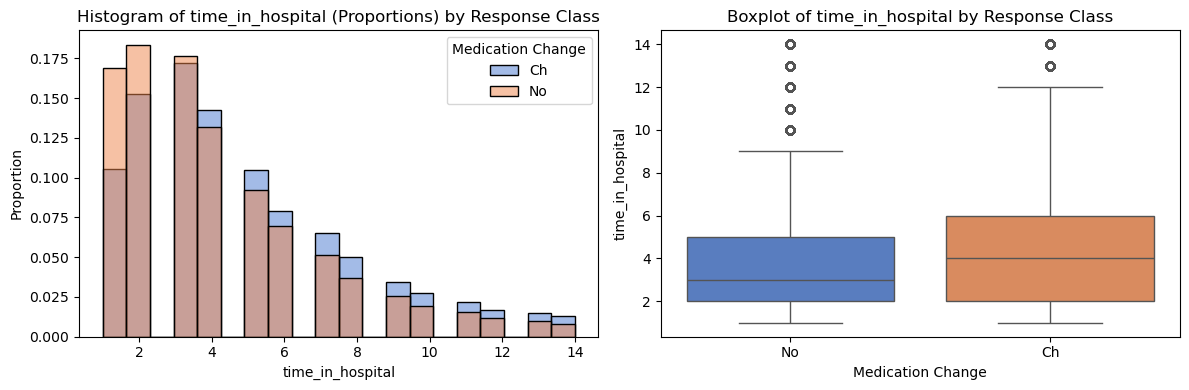

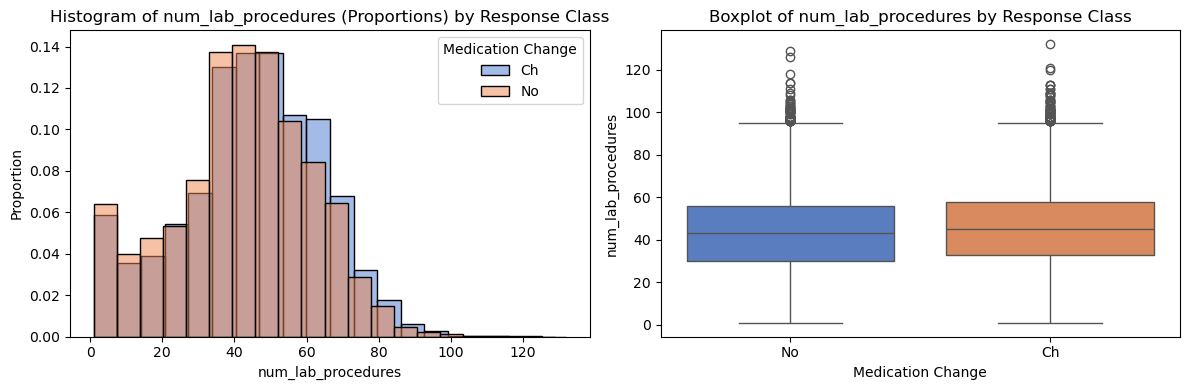

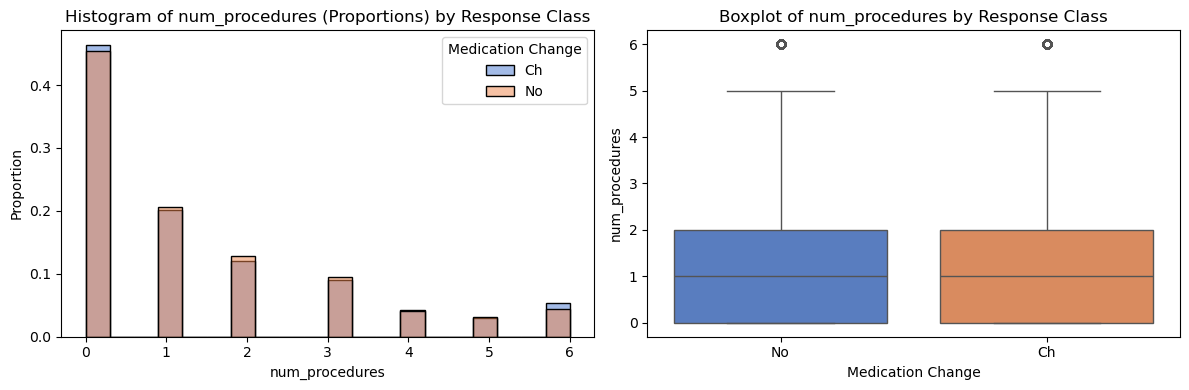

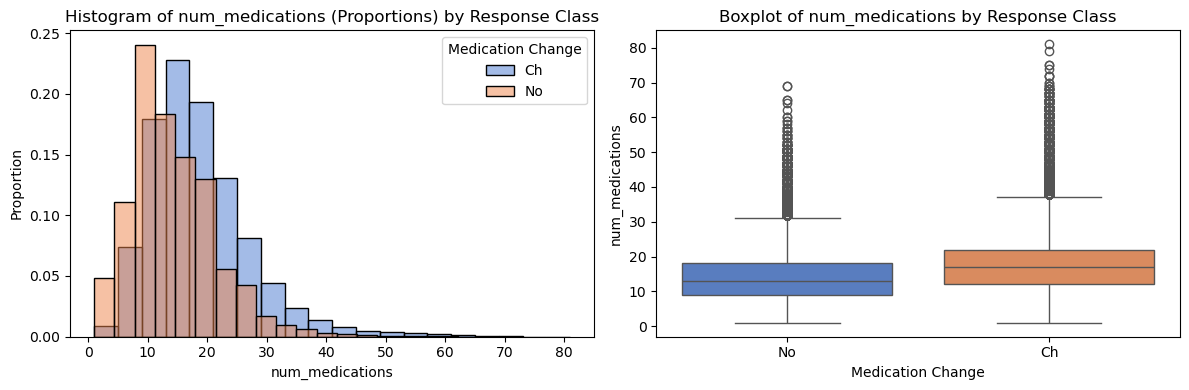

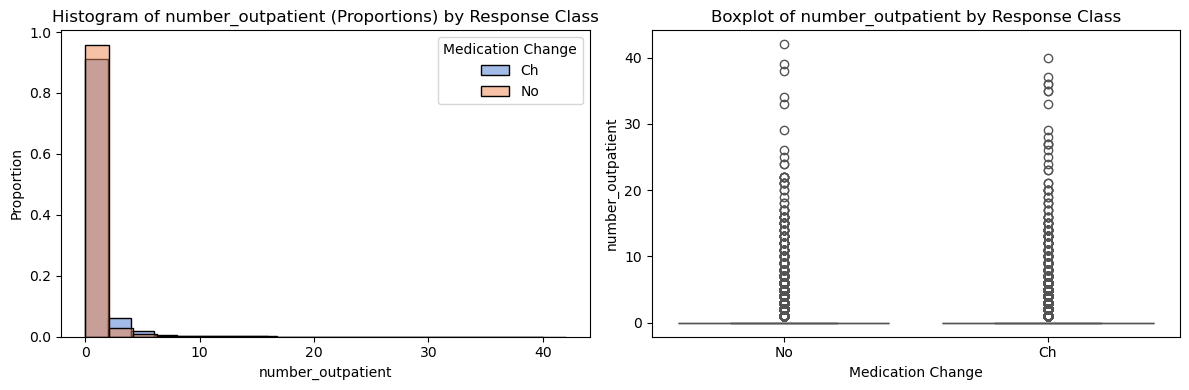

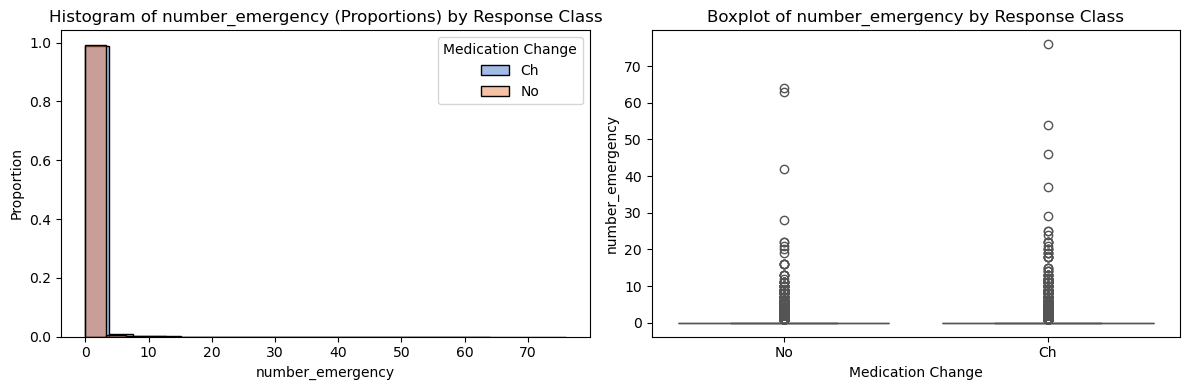

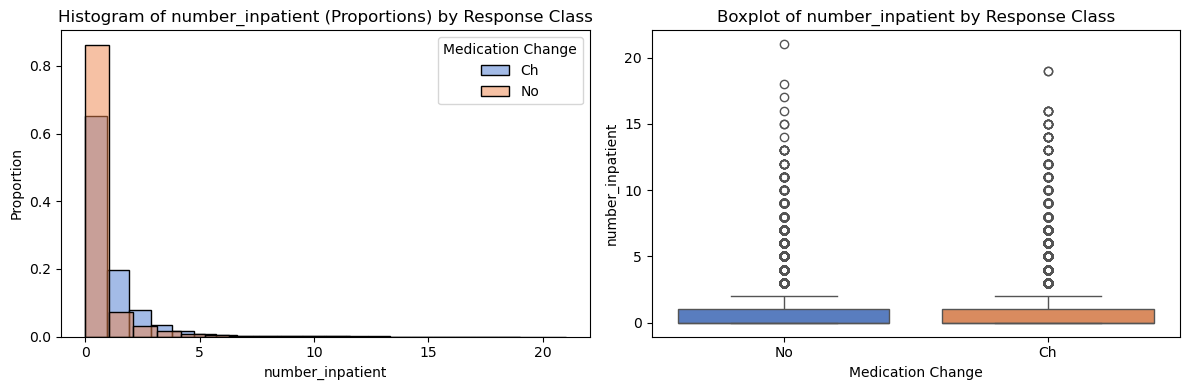

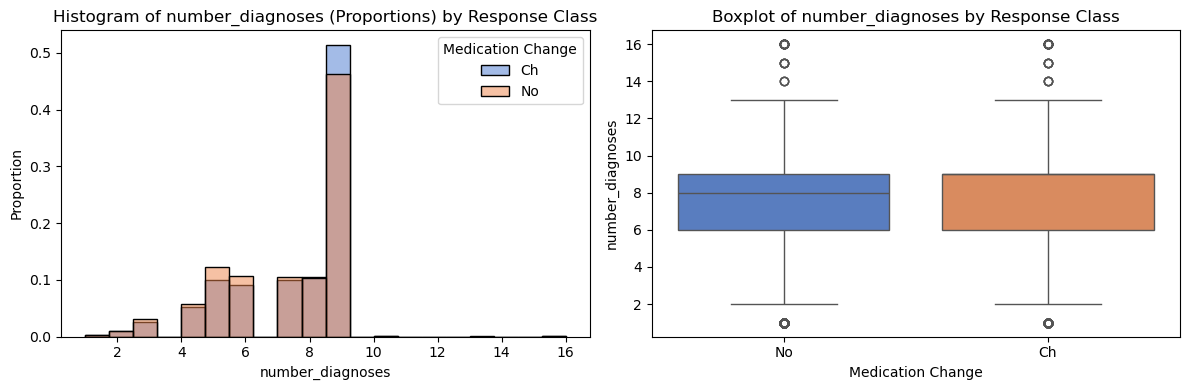

In [4]:
change_order = ['Ch', 'No']

# List of numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Set the color palette
palette = sns.color_palette("muted", n_colors=len(change_order))

# Generate plots for each numeric column
for col in numeric_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Histogram with proportions
    for idx, category in enumerate(change_order):
        subset = df_clean[df_clean['change'] == category]
        sns.histplot(subset[col], bins=20, color=palette[idx], label=category, alpha=0.5, stat="probability", ax=axes[0])

    axes[0].set_title(f"Histogram of {col} (Proportions) by Response Class")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Medication Change')

    # Boxplot
    sns.boxplot(data=df_clean, x='change', y=col, hue='change', palette=palette[:len(change_order)], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col} by Response Class")
    axes[1].set_xlabel('Medication Change')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    # plt.savefig(f'plots/plot_{col}_by_readmitted.png', bbox_inches="tight") 
    plt.show()

This creates cross-tabulations for each categorical variable by response class, showing the percentage of patients in each category.

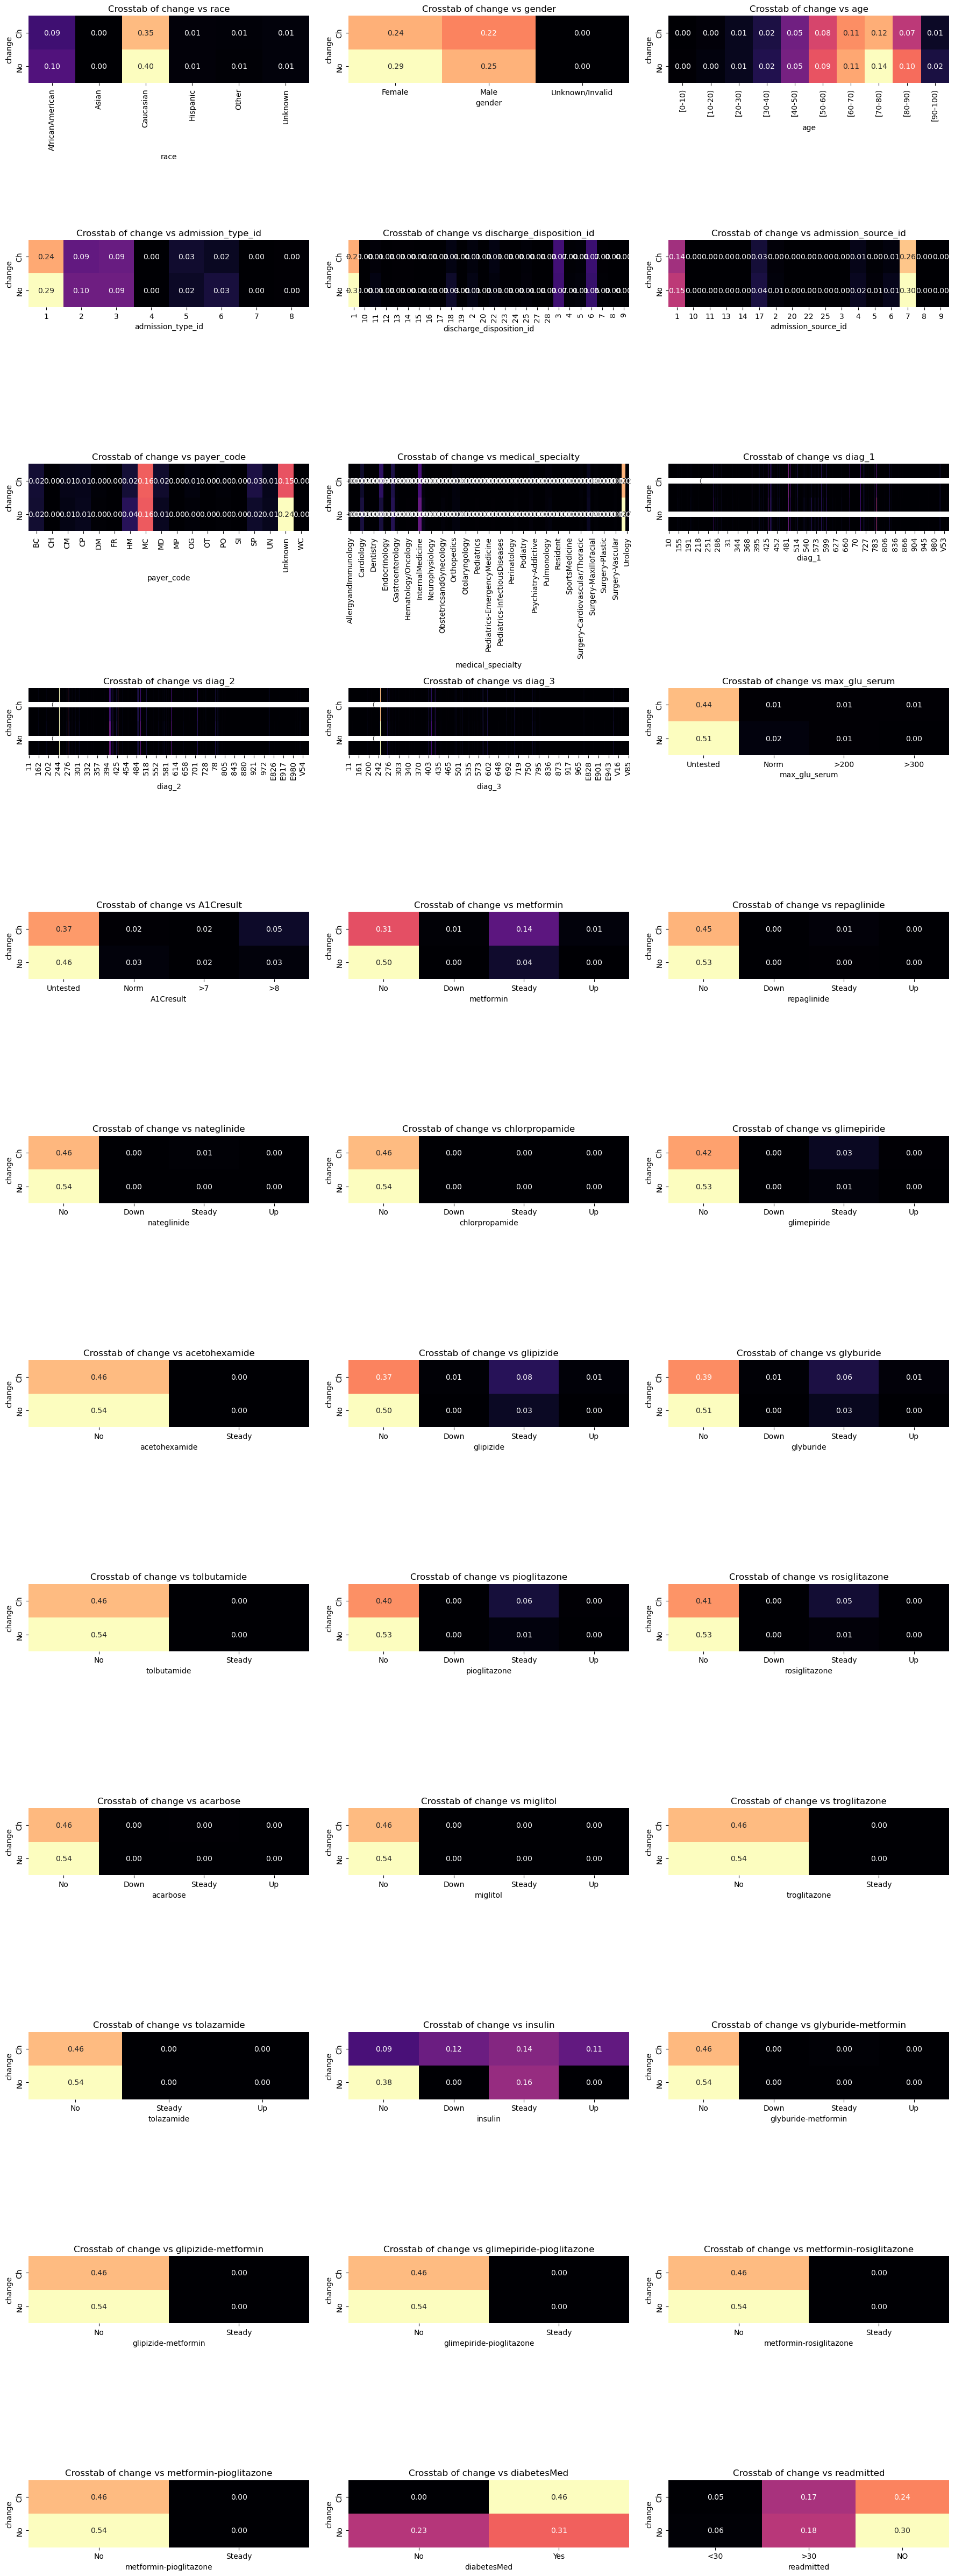

In [5]:
subset_df = df_clean.select_dtypes(include=['object', 'category'])
# subset_df = subset_df.drop(['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'patient_nbr', 'admission_type_id', 'max_glu_serum', 'A1Cresult'], axis=1)

# subset_df.columns

response = 'change'  # Attribute of interest
other_columns = [col for col in subset_df.columns if col != response]  # Exclude target

crosstab_results = {}
for column in other_columns:
    crosstab_results[column] = pd.crosstab(subset_df[response], subset_df[column])

def create_heatmaps(crosstab_results, response, normalization='none', n_cols=4, cmap="plasma"):
    """
    Creates a grid of heatmaps for given crosstab results.

    Parameters:
        crosstab_results (dict): Dictionary of crosstabs for each feature.
        response (str): Name of the response variable.
        normalization (str): Normalization type ('row', 'column', 'overall').
        n_cols (int): Number of columns in the subplot grid.
        cmap (str): Colormap for the heatmaps.
    """
    n_features = len(crosstab_results)  # Total features to plot
    n_rows = -(-n_features // n_cols)  # Compute rows by rounding up

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=False, sharey=False)
    axes = np.ravel(axes)  # Flatten axes for consistent 1D handling

    # Loop through crosstabs and create heatmaps
    for i, (col, crosstab) in enumerate(crosstab_results.items()):
        
        # Normalize the crosstab based on the selected normalization
        if normalization == 'none':
            normalized_crosstab = crosstab 
        elif normalization == 'row':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)    # Normalize by row
        elif normalization == 'column':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=0), axis=1)    # Normalize by column
        elif normalization == 'overall':
            normalized_crosstab = crosstab / crosstab.values.sum()              # Normalize overall
        else:
            raise ValueError("Invalid normalization type. Choose 'none', row', 'column', or 'overall'.")

        # Plot heatmap
        sns.heatmap(normalized_crosstab, annot=True, fmt=".2f" if normalization != 'none' else "d", cmap=cmap, cbar=False, ax=axes[i])
        
        axes[i].set_title(f"Crosstab of {response} vs {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(response)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    # plt.savefig(f'plots/crossTab_heatmaps.png')
    plt.show()

# create_heatmaps(crosstab_results, response='readmitted', normalization='none', n_cols=4, cmap="plasma")       #   Crosstab Heatmap: No Normalization, Raw Counts
# create_heatmaps(crosstab_results, response='readmitted', normalization='row', n_cols=4, cmap="plasma")        #   Crosstab Heatmap: No Normalization, Proportion of Factor Levels within the Response Variable
# create_heatmaps(crosstab_results, response='readmitted', normalization='column', n_cols=4, cmap="plasma")     #   Crosstab Heatmap: Column Normalization, Proportion of Factor Levels within the Predictor Variable
create_heatmaps(crosstab_results, response='change', normalization='overall', n_cols=3, cmap="magma")      #   Crosstab Heatmap: Overall Normalization, Proportion of Total Data


- Histograms and boxplots of numerical variables showed differences in distribution for `time_in_hospital` and `num_medications` across response classes.
- Categorical variables such as `insulin`, `diabetesMed`, `readmitted status`, and various medication/testing variables displayed different distributions between groups, suggesting they could be useful predictors.


#### Separating the Explanatory and Response Variables

In [6]:
# Extract response variable
y_change = df_clean['change']
X_change = df_clean.drop(columns=['change'])

# Convert target variable to a binary numeric (1 for 'Ch', 0 for 'No')
y_binary = y_change.copy()
y_binary = np.where(y_change == 'Ch', 1, 0)

#### Encoding & Scaling

In [7]:
# Define categorical and numerical feature subsets
categorical_cols = X_change.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_change.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables
X_change_encoded = pd.get_dummies(X_change, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues

# Define the preprocessing pipeline
# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')


- The response variable `change` was separated from the explanatory features.
- Categorical variables were encoded, and scaling was applied to numerical variables for appropriate models.
  

#### Strategy for Performance Validation

- The dataset was split into training and holdout sets (80/20 split) while stratifying the response variable to maintain class balance.
- A stratified $k$-fold cross-validation (CV) approach was used:
  - Feature selection and hyperparameter tuning were performed using 2-5 fold CV, depending on computational constraints.
  - To speed up hyperparameter tuning, a 50% subsample of the training data was used.
  - Final model comparison was conducted using 10-fold CV to obtain stable estimates of performance and generalization. 
- The holdout test set (20%) was reserved for final model evaluation after tuning.
- Given the dataset size (~100,000 records), an 80/20 split was chosen to:
  1. Ensure sufficient samples for training and validation, while leaving enough data for an unbiased test set.
  2. Preserve representation across categories, ensuring the training set captures the variance in categorical features.


#### Creating a Stratified Holdout Test Set

In [8]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_change_encoded, y_binary, test_size=0.2, random_state=1234)

#### Feature Engineering & Selection

In [9]:
# ----- LASSO Feature Selection -----
start_time = time.time()

lasso_selector = LassoCV(cv=5, random_state=1234)

# Create a pipeline with preprocessing and LASSO
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', lasso_selector)
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Retrieve feature names after transformation
feature_names = numerical_cols.tolist() + [col for col in X_train.columns if col not in numerical_cols]

# Select features with non-zero coefficients
lasso_selected_features = [feature_names[i] for i in range(len(feature_names)) if lasso_selector.coef_[i] != 0]

print(f"LASSO time: {(time.time() - start_time)/60:.2f} minutes")

# ----- Random Forest Feature Selection -----
start_time = time.time()

rf_selector = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_selector.fit(X_train, y_train)

# Get feature importances and select top features
feature_importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns)
rf_selected_features = feature_importances[feature_importances > np.percentile(feature_importances, 75)].index.tolist()  # Top 25% features

print(f"RF time: {(time.time() - start_time)/60:.2f} minutes")

# - `lasso_selected_features` is the list of features selected by LASSO
# - `rf_selected_features` is the list of features selected by Random Forest
# - `X_change` is the original dataset before encoding
# - `categorical_cols` and `numerical_cols` are already defined

# Convert feature lists to DataFrames for processing
lasso_df = pd.DataFrame({'Feature': lasso_selected_features})
rf_df = pd.DataFrame({'Feature': rf_selected_features})

# ----- Extract Original Variable Names for LASSO -----
lasso_numeric = lasso_df['Feature'][lasso_df['Feature'].isin(numerical_cols)]
lasso_categorical = lasso_df['Feature'][~lasso_df['Feature'].isin(numerical_cols)]
lasso_original_categorical = lasso_categorical.str.replace(r'_[^_]+$', '', regex=True)  # Remove one-hot encoding suffixes

# Combine numeric and cleaned categorical features
lasso_unique_features = pd.concat([lasso_numeric, lasso_original_categorical]).unique()

# ----- Extract Original Variable Names for Random Forest -----
rf_numeric = rf_df['Feature'][rf_df['Feature'].isin(numerical_cols)]
rf_categorical = rf_df['Feature'][~rf_df['Feature'].isin(numerical_cols)]
rf_original_categorical = rf_categorical.str.replace(r'_[^_]+$', '', regex=True)

# Combine numeric and cleaned categorical features
rf_unique_features = pd.concat([rf_numeric, rf_original_categorical]).unique()

# ----- Find Common & Unused Features -----
dataset_features = pd.Series(X_change.columns)  # Original dataset BEFORE encoding

# Features selected by both LASSO & RF
common_features = pd.Series(list(set(lasso_unique_features) & set(rf_unique_features)))

# Features in dataset but not selected by either method
unused_features = dataset_features[~dataset_features.isin(pd.concat([pd.Series(lasso_unique_features), pd.Series(rf_unique_features)]))]

# Print Results
print("\nLASSO Unique Selected Features (Original Variables):")
print(lasso_unique_features)

print("\nRandom Forest Unique Selected Features (Original Variables):")
print(rf_unique_features)

print("\nCommon Features Selected by Both LASSO and RF:")
print(common_features.to_list())

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO or RF):")
print(unused_features.to_list())


LASSO time: 0.30 minutes
RF time: 3.63 minutes

LASSO Unique Selected Features (Original Variables):
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'race' 'gender' 'age'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'payer_code' 'medical_specialty' 'diag_1' 'diag_2' 'diag_3'
 'max_glu_serum' 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide'
 'chlorpropamide' 'glimepiride' 'glipizide' 'glyburide' 'pioglitazone'
 'rosiglitazone' 'acarbose' 'insulin' 'glyburide-metformin' 'diabetesMed'
 'readmitted']

Random Forest Unique Selected Features (Original Variables):
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'race' 'gender' 'age'
 'admission_type_id' 'discharge_disposition_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'metformin' 'r

#### Creating a Reduced Dataset with Important Variables (`X_train_selected` and `X_test_selected`)

In [10]:
# Train/test split was already created. Do this to avoid leakage.

# Identify encoded features corresponding to original features selected by both LASSO and RF
selected_encoded_features = [col for col in X_train.columns if any(feature in col for feature in common_features)]

# Create a Reduced Dataset with Encoded Features
X_train_selected = X_train[selected_encoded_features].copy()
X_test_selected = X_test[selected_encoded_features].copy()  # Ensure same columns in test set

# Ensure train and test have the same columns (Test set may lack some categories)
X_test_selected = X_test_selected.reindex(columns=X_train_selected.columns, fill_value=0)

# Final check
print("Final Training Shape:", X_train_selected.shape)
print("Final Testing Shape:", X_test_selected.shape)

Final Training Shape: (81412, 2351)
Final Testing Shape: (20354, 2351)


#### Creating a Second Dataset Filtering to Fewer Variables (`X_train_super_reduced` and `X_test_super_reduced`)

In [11]:
# Reducing the dataset further just to see...
# Because accuracy is so high, maybe we don't need all of these features and based on EDA we can drop several.

# Super Reduced Dataset
# Only key medication & two numerical features
# super_reduced_features = ['glyburide-metformin', 'glyburide', 'acarbose', 'rosiglitazone', 'pioglitazone', 'repaglinide',
#                           'metformin', 'nateglinide', 'diabetesMed', 'glimepiride', 'glipizide', 'chlorpropamide', 
#                           'insulin', 'num_medications', 'time_in_hospital']

# Only key medication features
# super_reduced_features = ['glyburide-metformin', 'glyburide', 'acarbose', 'rosiglitazone', 'pioglitazone', 'repaglinide',
#                           'metformin', 'nateglinide', 'glimepiride', 'glipizide', 'chlorpropamide', 
#                           'insulin']

# Medication variables with the largest variation between levels (top level < 90%)
# super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin']
# These 4 give these results:
# Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9295, AUC: 0.9571, F1: 0.9175

# Medication variables with most frequent levels < 95%)
# super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin', 'glimepiride', 'rosiglitazone', 'pioglitazone']
# These 7 give these results:
# Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9891, AUC: 0.9941, F1: 0.9881

super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin', 'glimepiride', 'rosiglitazone', 'pioglitazone', 'repaglinide']
super_reduced_encoded_features = [col for col in X_train.columns if any(feature in col for feature in super_reduced_features)]

# Create the super reduced dataset
X_train_super_reduced = X_train[super_reduced_encoded_features].copy()
X_test_super_reduced = X_test[super_reduced_encoded_features].copy()
X_test_super_reduced = X_test_super_reduced.reindex(columns=X_train_super_reduced.columns, fill_value=0)

print("Super Reduced Training Shape:", X_train_super_reduced.shape)
print("Super Reduced Testing Shape:", X_test_super_reduced.shape)

# In case we want to add numerical variables
# Only keep numerical columns that exist in the super reduced dataset
numerical_cols_reduced = [col for col in numerical_cols if col in X_train_super_reduced.columns]

# Update the preprocessor with the new numerical columns
preprocessor_reduced = ColumnTransformer([('num', StandardScaler(), numerical_cols_reduced)], remainder='passthrough')


Super Reduced Training Shape: (81412, 39)
Super Reduced Testing Shape: (20354, 39)



- An initial feature selection process reduced the dataset to the most important variables.
- A further-reduced dataset was created, retaining only 8 highly relevant medication-related features.
- Modeling and evaluation were performed with both sets.


## Modeling & Evaluation: Classification Task

#### Define Classifiers

We tested four classifiers:  
1. **SGD Logistic Regression**  
   - Selected for interpretability and computational efficiency when applied to large datasets.
2. **SGD Support Vector Machine (SVM)**  
   - Chosen as a similar alternative to Logistic Regression with potentially better decision boundaries.
3. **Multinomial Naive Bayes**  
   - Selected for computational efficiency due to its probabalistic nature. A multinomial version was selected because the data are neither all Gaussian or binary.
4. **AdaBoost Decision Tree**  
   - Included for its ensemble-based flexibility and ability to improve weak learners.


In [12]:
# Define Classifiers
clf_lr = SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-05, eta0=0.01,
                       max_iter=500, class_weight="balanced",
                       learning_rate="adaptive", n_jobs=2, random_state=1234)
clf_svm = SGDClassifier(loss="hinge", penalty="l2", # Hinge loss for SVM
                            max_iter=500, class_weight="balanced",
                            n_jobs=-1, random_state=1234)
clf_nb = MultinomialNB(alpha=0.5)  # Tune alpha later
clf_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1, class_weight='balanced'),
                            learning_rate=0.5, # Tune small to prevent overfitting and larger to increase contribution of each classifier
                            n_estimators=200)  # Tune estimators later 

# Define classifier labels
clf_labels = ['SGD Logistic Regression', 'SGD Support Vector Machine', 'Multinomial Naive Bayes', 'AdaBoost Decision Tree']

# Pipelines
clf_lr_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_lr)])
clf_svm_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_svm)])
# clf_nb # No scaling needed
clf_dt_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_dt)])


#### Tune Hyperparameters 

To equally prioritize predicting patients both with and without a change in medication, we chose to use overall accuracy to tune our models.

For each model, hyperparameters were tuned to optimize performance. Key parameters included:  
- **SGD Logistic Regression**  
  - `penalty`: L1 (Lasso) vs. L2 (Ridge) regularization to prevent overfitting.
  - `alpha`: Regularization strength (penalizes large coefficients; small values allow for less regularization, capturing more complex patterns; larger values result in stronger regularization, which prevents overfitting).
  - `eta0`: Initial learning rate only when using an adaptive learning schedule (if too small, model learns slowly needs more iterations to converge; if too large, updates may overshoot the optimal solution and will failt to converge).
  - `learning_rate`: Tested between `optimal` (predefined step-size schedule) and `adaptive` (adjusted dynamically based on updates).
  - `max_iter`: Maximum number of iterations to allow the model to converge.    
- **SGD Support Vector Machine (SVM)**  
  - Uses the same hyperparameters as SGD Logistic Regression, but it optimizes hinge loss instead of log loss.   
- **Multinomial Naive Bayes**  
  - `alpha`: Smoothing parameter (higher values avoid zero probabilities but can overly smooth the estimates).
  - `class_prior`: Explicit priors were tested, in case of a benefit to artificially weighting classes in favor of detecting medication changes.   
- **AdaBoost Decision Tree**  
  - `n_estimators`: Number of boosting iterations (higher values increase complexity but risk overfitting and also slow down tuning).
  - `learning_rate`: Controls how much each weak learner contributes to the final prediction (lower learning_rate, more weak learners needed, smaller updates; higher learning_rate, fewer weak learners needed, larger contribution, risk of overfitting).  


In [13]:
# Tune on a subset of of X_train the training data
# Underscores are variables returned but not needed
X_train_tune, _, y_train_tune, _ = train_test_split(X_train, y_train, train_size=0.5, stratify=y_train, random_state=1234)

print(f"Original training set size: {X_train.shape[0]}")
print(f"Subset size for tuning: {X_train_tune.shape[0]}")

# Hyperparameter tuning for SGDClassifier (Logistic Regression with SGD)
start_time = time.time()

param_grid_lr = {
    'clf__penalty': ['l1', 'l2'], #l1 is lasso
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__eta0': [0.001, 0.01],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_lr = GridSearchCV(
    clf_lr_pipeline, param_grid_lr, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_lr = HalvingGridSearchCV(
#     clf_lr_pipeline, param_grid_lr, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,  # Uses at most ~half of training data
#     return_train_score=True, n_jobs=-1
# )
grid_lr.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nLogistic Regression (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_lr.cv_results_['param_clf__penalty'],
    grid_lr.cv_results_['param_clf__alpha'],
    grid_lr.cv_results_['param_clf__eta0'],
    grid_lr.cv_results_['param_clf__learning_rate'],
    grid_lr.cv_results_['param_clf__max_iter'],
    grid_lr.cv_results_['mean_test_accuracy'],
    grid_lr.cv_results_['mean_test_roc_auc'],
    grid_lr.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_lr.best_params_['clf__penalty']
best_alpha = grid_lr.best_params_['clf__alpha']
best_eta0 = grid_lr.best_params_['clf__eta0']
best_learning_rate = grid_lr.best_params_['clf__learning_rate']
best_max_iter = grid_lr.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for Logistic Regression (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")

# Update SGDClassifier with best hyperparameters
clf_lr_pipeline.set_params(clf__penalty=best_penalty)
clf_lr_pipeline.set_params(clf__alpha=best_alpha)
clf_lr_pipeline.set_params(clf__eta0=best_eta0)
clf_lr_pipeline.set_params(clf__learning_rate=best_learning_rate)
clf_lr_pipeline.set_params(clf__max_iter=best_max_iter)

print(f"LR Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for SGDClassifier (Support Vector Machine with SGD)
start_time = time.time()

param_grid_svm = {
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__eta0': [0.001, 0.01, 0.1],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_svm = GridSearchCV(
    clf_svm_pipeline, param_grid_svm, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_svm = HalvingGridSearchCV(
#     clf_svm_pipeline, param_grid_svm, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True, n_jobs=-1
# )
grid_svm.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nSVM (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_svm.cv_results_['param_clf__penalty'],
    grid_svm.cv_results_['param_clf__alpha'],
    grid_svm.cv_results_['param_clf__eta0'],
    grid_svm.cv_results_['param_clf__learning_rate'],
    grid_svm.cv_results_['param_clf__max_iter'],
    grid_svm.cv_results_['mean_test_accuracy'],
    grid_svm.cv_results_['mean_test_roc_auc'],
    grid_svm.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_svm.best_params_['clf__penalty']
best_alpha = grid_svm.best_params_['clf__alpha']
best_eta0 = grid_svm.best_params_['clf__eta0']
best_learning_rate = grid_svm.best_params_['clf__learning_rate']
best_max_iter = grid_svm.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for SVM (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")


# Update SGDClassifier with best hyperparameters
clf_svm_pipeline.set_params(clf__penalty=best_penalty)
clf_svm_pipeline.set_params(clf__alpha=best_alpha)
clf_svm_pipeline.set_params(clf__eta0=best_eta0)
clf_svm_pipeline.set_params(clf__learning_rate=best_learning_rate)
clf_svm_pipeline.set_params(clf__max_iter=best_max_iter)

print(f"SVM Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for MultinomialNB
start_time = time.time()

param_grid_nb = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'class_prior': [(0.3, 0.7), (0.4, 0.6), (0.46, 0.54), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]  # Yes=46%
}

grid_nb = GridSearchCV(
    clf_nb, param_grid_nb, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_nb = HalvingGridSearchCV(
#     clf_nb, param_grid_nb, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_nb.fit(X_train_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nMultinomialNB - Hyperparameter Performance:")
for alpha, class_prior, acc, auc, f1 in zip(
    grid_nb.cv_results_['param_alpha'],
    grid_nb.cv_results_['param_class_prior'],
    grid_nb.cv_results_['mean_test_accuracy'],
    grid_nb.cv_results_['mean_test_roc_auc'],
    grid_nb.cv_results_['mean_test_f1']
):
    print(f"Alpha: {alpha}, Class Prior: {class_prior}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best alpha and class_prior
best_alpha = grid_nb.best_params_['alpha']
best_class_prior = grid_nb.best_params_['class_prior']
print(f"\nBest alpha for MNB: {best_alpha}, Best class prior: {best_class_prior}")

# Update NB classifier with best hyperparameters
clf_nb = MultinomialNB(alpha=best_alpha, class_prior=best_class_prior)

print(f"NB Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for AdaBoost
start_time = time.time()

param_grid_ab = {'clf__n_estimators': [50, 100, 200],
                 'clf__learning_rate': [0.1, 0.5, 1.0, 1.5]}

grid_ab = GridSearchCV(
    clf_dt_pipeline, param_grid_ab, cv=2, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_ab = HalvingGridSearchCV(
#     clf_dt_pipeline, param_grid_ab, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_ab.fit(X_train_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nAdaBoost - Hyperparameter Performance:")
for n_estimators, learning_rate, acc, auc, f1 in zip(
    grid_ab.cv_results_['param_clf__n_estimators'], 
    grid_ab.cv_results_['param_clf__learning_rate'],
    grid_ab.cv_results_['mean_test_accuracy'],
    grid_ab.cv_results_['mean_test_roc_auc'],
    grid_ab.cv_results_['mean_test_f1']
):
    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best n_estimators and learning_rate
best_n_estimators = grid_ab.best_params_['clf__n_estimators']
best_learning_rate = grid_ab.best_params_['clf__learning_rate']
print(f"\nBest n_estimators for AdaBoost: {best_n_estimators}, Best learning_rate: {best_learning_rate}")

# Update AdaBoost classifier with best n_estimators
clf_dt_pipeline.set_params(clf__n_estimators=best_n_estimators)
clf_dt_pipeline.set_params(clf__learning_rate=best_learning_rate)

print(f"AdaBoost Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


Original training set size: 81412
Subset size for tuning: 40706

Logistic Regression (SGD) Classifier - Hyperparameter Performance:
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9975, AUC: 0.9984, F1: 0.9973
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9945, AUC: 0.9981, F1: 0.9940
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9822, AUC: 0.9944, F1: 0.9804
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9821, AUC: 0.9938, F1: 0.9803
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9975, AUC: 0.9984, F1: 0.9973
Penalty: l2, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9945, AUC: 0.9981, F1: 0.9940
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9955, AUC: 0.9979, F1: 0.9951
Penalty: l2, A

#### Cross-Validate Classifiers (SGD Logistic Regression, SGD Support Vector Machine, Multinomial Naive Bayes, and AdaBoost Decision Tree)

In [14]:
start_time_total = time.time()  # Track total time

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Dictionary to store model training times and accuracy scores
cv_times = {}
cv_accuracy_scores = {}  # Store accuracy scores for each model

# Cross-validation: Recall, Accuracy, F1
print("\n10-fold Cross-Validation Metrics:\n")
for clf, label in zip([clf_lr_pipeline, clf_svm_pipeline, clf_nb, clf_dt_pipeline], clf_labels):
    
    start_time = time.time()  # Start timing for the model
    
    # Compute and store accuracy scores
    accuracy_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_accuracy_scores[label] = accuracy_scores  # Store for later use
    
    # Compute and display AUC and F1 scores
    roc_auc_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='f1', n_jobs=-1)

    end_time = time.time()  # End timing
    
    # Store elapsed time in minutes
    cv_times[label] = (end_time - start_time) / 60 
    
    print(f"{label}:")
    print(f"  CV Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  CV AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print(f"  CV F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})\n")


# Print Cross-Validation Timing Per Model
print("\nCross-Validation Time per Model (in minutes):")
for model, time_taken in cv_times.items():
    print(f"{model}: {time_taken:.2f} minutes")

# Print Total Time Taken
end_time_total = time.time()
print(f"\nTotal Elapsed Time for Cross-Validation: {(end_time_total - start_time_total)/60:.2f} minutes")



10-fold Cross-Validation Metrics:

SGD Logistic Regression:
  CV Accuracy: 0.998 (+/- 0.000)
  CV AUC: 0.999 (+/- 0.000)
  CV F1 Score: 0.998 (+/- 0.000)

SGD Support Vector Machine:
  CV Accuracy: 1.000 (+/- 0.000)
  CV AUC: 1.000 (+/- 0.000)
  CV F1 Score: 1.000 (+/- 0.000)

Multinomial Naive Bayes:
  CV Accuracy: 0.853 (+/- 0.004)
  CV AUC: 0.932 (+/- 0.002)
  CV F1 Score: 0.834 (+/- 0.004)

AdaBoost Decision Tree:
  CV Accuracy: 0.833 (+/- 0.003)
  CV AUC: 0.903 (+/- 0.002)
  CV F1 Score: 0.801 (+/- 0.004)


Cross-Validation Time per Model (in minutes):
SGD Logistic Regression: 1.81 minutes
SGD Support Vector Machine: 5.33 minutes
Multinomial Naive Bayes: 0.47 minutes
AdaBoost Decision Tree: 2.43 minutes

Total Elapsed Time for Cross-Validation: 10.04 minutes


#### Statistical Comparison of Models

To determine whether the performance differences were statistically significant, we performed paired t-tests with a Bonferroni correction and Tukey’s HSD Test.


In [16]:
# Extract accuracy scores from dictionary
lr_acc = cv_accuracy_scores["SGD Logistic Regression"]
svm_acc = cv_accuracy_scores["SGD Support Vector Machine"]
nb_acc = cv_accuracy_scores["Multinomial Naive Bayes"]
dt_acc = cv_accuracy_scores["AdaBoost Decision Tree"]

# Define all model pairs for pairwise comparisons
model_pairs = [
    ("SGD Logistic Regression", "SGD Support Vector Machine", lr_acc, svm_acc),
    ("SGD Logistic Regression", "Multinomial Naive Bayes", lr_acc, nb_acc),
    ("SGD Logistic Regression", "AdaBoost Decision Tree", lr_acc, dt_acc),
    ("SGD Support Vector Machine", "Multinomial Naive Bayes", svm_acc, nb_acc),
    ("SGD Support Vector Machine", "AdaBoost Decision Tree", svm_acc, dt_acc),
    ("Multinomial Naive Bayes", "AdaBoost Decision Tree", nb_acc, dt_acc),
]

# Perform paired t-tests
p_values = []
t_stats = []

print("\nPairwise t-test results:")
for name1, name2, acc1, acc2 in model_pairs:
    t_stat, p_val = ttest_rel(acc1, acc2)
    t_stats.append(t_stat)
    p_values.append(p_val)
    print(f"{name1} vs {name2}: t = {t_stat:.3f}, p = {p_val:.5f}")

# Apply Bonferroni correction
_, p_corrected_bonferroni, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("\nBonferroni-corrected p-values:")
for i, (name1, name2, _, _) in enumerate(model_pairs):
    print(f"{name1} vs {name2}: p = {p_corrected_bonferroni[i]:.5f}")

# === Tukey's HSD Test ===
# Combine all accuracy scores into a single array
all_scores = np.concatenate([lr_acc, svm_acc, nb_acc, dt_acc])

# Create labels for each model (repeated for each fold)
model_labels = (["SGD Logistic Regression"] * len(lr_acc) +
                ["SGD Support Vector Machine"] * len(svm_acc) +
                ["Multinomial Naive Bayes"] * len(nb_acc) +
                ["AdaBoost Decision Tree"] * len(dt_acc))

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_scores, model_labels, alpha=0.05)

print("\nTukey's HSD Test Results:")
print(tukey_results)



Pairwise t-test results:
SGD Logistic Regression vs SGD Support Vector Machine: t = -15.749, p = 0.00000
SGD Logistic Regression vs Multinomial Naive Bayes: t = 121.308, p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: t = 184.556, p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: t = 121.484, p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: t = 180.937, p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: t = 20.352, p = 0.00000

Bonferroni-corrected p-values:
SGD Logistic Regression vs SGD Support Vector Machine: p = 0.00000
SGD Logistic Regression vs Multinomial Naive Bayes: p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: p = 0.00000

Tukey's HSD Test Results:
                  Multiple Comparison of Means - Tukey HSD

**Paired t-tests with Bonferroni correction**
- Compared paired accuracy scores across cross-validation folds.
- Found a statistically significant difference between all models.

**Tukey’s HSD Test**
- Compared model accuracy as independent groups not as paired observations (folds).
- More appropriate for comparing mean accuracy of many models.
- Typically less conservative than the Bonferroni.
- Did not find a significant difference between SGD Logistic Regression and SVM.
- Confirmed Naive Bayes and AdaBoost were significantly different from the SGD-based models.

Though Logistic Regression vs. SVM was statistically significant using Bonferroni-corrected paired t-test, the difference was very small. Practically, Logistic Regression and SVM perform equivalently.
  

#### Evaluate Classifiers on the Holdout Set


Performance Metrics for SGD Logistic Regression:
  Accuracy: 0.9979
  ROC AUC: 0.9986
  F1 Score: 0.9978
  Precision: 0.9997
  Recall: 0.9958

Performance Metrics for SGD Support Vector Machine:
  Accuracy: 0.9999
  ROC AUC: 0.9999
  F1 Score: 0.9999
  Precision: 1.0000
  Recall: 0.9998

Performance Metrics for Multinomial Naive Bayes:
  Accuracy: 0.8531
  ROC AUC: 0.9321
  F1 Score: 0.8345
  Precision: 0.8661
  Recall: 0.8052

Performance Metrics for AdaBoost Decision Tree:
  Accuracy: 0.8337
  ROC AUC: 0.9029
  F1 Score: 0.8020
  Precision: 0.8865
  Recall: 0.7322




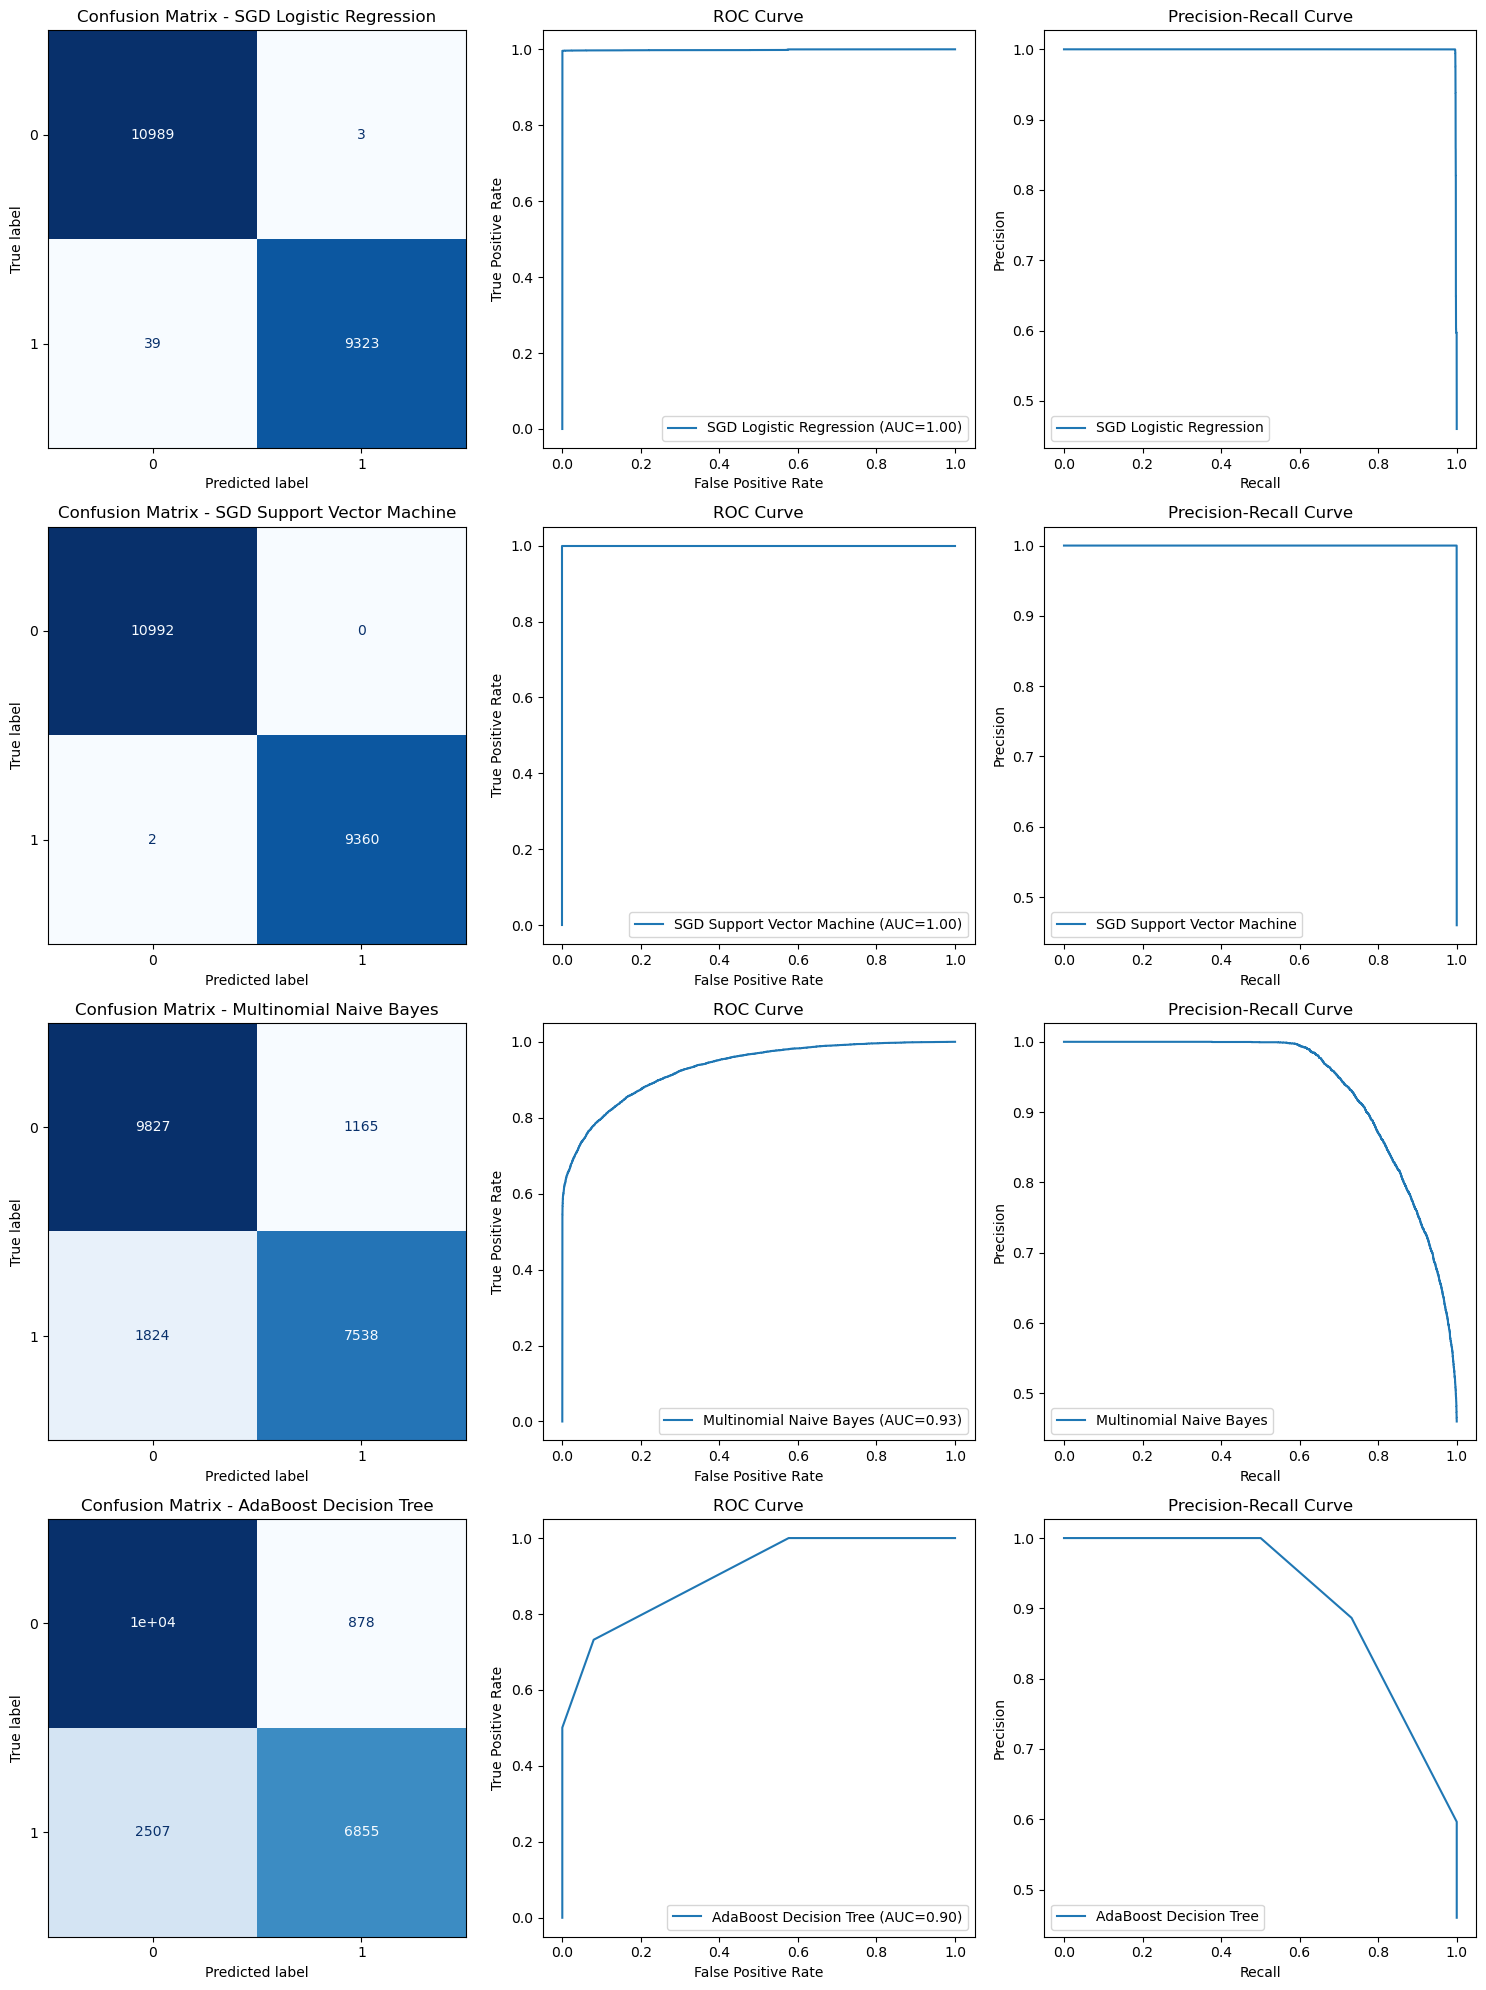

In [17]:
# Fit the models
clf_lr_pipeline.fit(X_train, y_train)
clf_svm_pipeline.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)
clf_dt_pipeline.fit(X_train, y_train)

# Create subplots for CM, ROC, and PR curves
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # 4 rows, 3 columns (CM, PR, ROC)

for i, (clf, label) in enumerate(zip([clf_lr_pipeline, clf_svm_pipeline, clf_nb, clf_dt_pipeline], clf_labels)):
    
    # Predictions
    y_test_pred = clf.predict(X_test)
    # Use predict_proba() if available; otherwise, use decision_function()
    if hasattr(clf, "predict_proba"):
        y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    else:
        y_test_prob = clf.decision_function(X_test)  # Decision scores (not probabilities)

    # Confusion Matrix
    cm_test = mt.confusion_matrix(y_test, y_test_pred)
    cm_display = mt.ConfusionMatrixDisplay(cm_test)
    axes[i, 0].set_title(f"Confusion Matrix - {label}")
    cm_display.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)

    # ROC Curve
    fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
    axes[i, 1].plot(fpr, tpr, label=f"{label} (AUC={mt.roc_auc_score(y_test, y_test_prob):.2f})")
    axes[i, 1].set_title("ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="best")
    
    # Precision-Recall Curve
    precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
    axes[i, 2].plot(recall, precision, label=f"{label}")
    axes[i, 2].set_title("Precision-Recall Curve")
    axes[i, 2].set_xlabel("Recall")
    axes[i, 2].set_ylabel("Precision")
    axes[i, 2].legend(loc="best")

    # Print final metrics for comparison
    print(f"\nPerformance Metrics for {label}:")
    print(f"  Accuracy: {mt.accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC: {mt.roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"  F1 Score: {mt.f1_score(y_test, y_test_pred):.4f}")
    print(f"  Precision: {mt.precision_score(y_test, y_test_pred):.4f}")
    print(f"  Recall: {mt.recall_score(y_test, y_test_pred):.4f}")

print("\n")
plt.tight_layout()
plt.show()


- Chosen metrics based on the fact that it is equally important to predict patients with a medication change and those without.
  - **Accuracy** – Provides a general measure of correctness, which is appropriate given the balanced classes and the need for equal weight on both outcomes.
  - **ROC AUC** – A threshold-independent metric that visualizes the trade-off between true positives and false positives across different classification thresholds, helping assess overall model discrimination.
  - **F1 Score** – Balances precision and recall, ensuring that the model is not overly biased toward one class.
  - **Precision & Recall** – Helps analyze the trade-offs between minimizing false positives (incorrectly predicted medication changes) and false negatives (missed medication changes).

- Summary of the Plotted Evaluation Metrics (Full Feature Set)  
  - **Confusion Matrix (Left):** Shows correct and incorrect predictions.  
  - **ROC Curve & AUC Score (Middle):** Assesses the model’s ability to distinguish between classes across different thresholds.  
  - **Precision-Recall (PR) Curve (Right):** Visualizes the trade-off between precision and recall.  

Takeaways: 
- SGD Logistic Regression & SGD SVM
  - Nearly perfect classification with almost no false positives or false negatives (Logistic Regression: 3/39, SVM: 0/2)
  - ROC AUC = 1.00, meaning near perfect class separation.
  - PR Curve is ideal, showing near-perfect recall and precision.
  - Near perfect result poses the question, is this real?
- Multinomial Naive Bayes (Third Model)
  - More false negatives (1,824) and false positives (1,165).
  - ROC AUC = 0.93, good but weaker class separation than the SGD models.
- AdaBoost Decision Tree (Bottom Model)
  - More false negatives (2,507) and false positives (878) than SGD models and a different balance than Naive Bayes
  - ROC AUC = 0.90, still good but slightly weaker than Naive Bayes.


#### Tuning on Dataset with Even Fewer Features

In [18]:
# Tune on a subset of of X_train the training data
# Underscores are variables returned but not needed
X_train_super_reduced_tune, _, y_train_tune, _ = train_test_split(X_train_super_reduced, y_train, train_size=0.5, stratify=y_train, random_state=1234)

print(f"Original training set size: {X_train.shape[0]}")
print(f"Subset size for tuning: {X_train_tune.shape[0]}")


print('Results for Super Reduced Dataset')

# Pipelines
clf_lr_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_lr)])
clf_svm_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_svm)])
# clf_nb # No scaling needed
clf_dt_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_dt)])

# Hyperparameter tuning for SGDClassifier (Logistic Regression with SGD)
start_time = time.time()

param_grid_lr = {
    'clf__penalty': ['l1', 'l2'], #l1 is lasso
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__eta0': [0.001, 0.01],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_lr = GridSearchCV(
    clf_lr_pipeline_red, param_grid_lr, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_lr = HalvingGridSearchCV(
#     clf_lr_pipeline_red, param_grid_lr, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,  # Uses at most ~half of training data
#     return_train_score=True, n_jobs=-1
# )
grid_lr.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nLogistic Regression (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_lr.cv_results_['param_clf__penalty'],
    grid_lr.cv_results_['param_clf__alpha'],
    grid_lr.cv_results_['param_clf__eta0'],
    grid_lr.cv_results_['param_clf__learning_rate'],
    grid_lr.cv_results_['param_clf__max_iter'],
    grid_lr.cv_results_['mean_test_accuracy'],
    grid_lr.cv_results_['mean_test_roc_auc'],
    grid_lr.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_lr.best_params_['clf__penalty']
best_alpha = grid_lr.best_params_['clf__alpha']
best_eta0 = grid_lr.best_params_['clf__eta0']
best_learning_rate = grid_lr.best_params_['clf__learning_rate']
best_max_iter = grid_lr.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for Logistic Regression (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")

# Update SGDClassifier with best hyperparameters
clf_lr_pipeline_red.set_params(clf__penalty=best_penalty)
clf_lr_pipeline_red.set_params(clf__alpha=best_alpha)
clf_lr_pipeline_red.set_params(clf__eta0=best_eta0)
clf_lr_pipeline_red.set_params(clf__learning_rate=best_learning_rate)
clf_lr_pipeline_red.set_params(clf__max_iter=best_max_iter)

print(f"LR Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for SGDClassifier (Support Vector Machine with SGD)
start_time = time.time()

param_grid_svm = {
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__eta0': [0.001, 0.01, 0.1],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_svm = GridSearchCV(
    clf_svm_pipeline_red, param_grid_svm, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_svm = HalvingGridSearchCV(
#     clf_svm_pipeline_red, param_grid_svm, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True, n_jobs=-1
# )
grid_svm.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nSVM (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_svm.cv_results_['param_clf__penalty'],
    grid_svm.cv_results_['param_clf__alpha'],
    grid_svm.cv_results_['param_clf__eta0'],
    grid_svm.cv_results_['param_clf__learning_rate'],
    grid_svm.cv_results_['param_clf__max_iter'],
    grid_svm.cv_results_['mean_test_accuracy'],
    grid_svm.cv_results_['mean_test_roc_auc'],
    grid_svm.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_svm.best_params_['clf__penalty']
best_alpha = grid_svm.best_params_['clf__alpha']
best_eta0 = grid_svm.best_params_['clf__eta0']
best_learning_rate = grid_svm.best_params_['clf__learning_rate']
best_max_iter = grid_svm.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for SVM (SGD) Classifier - Penaly: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")


# Update SGDClassifier with best hyperparameters
clf_svm_pipeline_red.set_params(clf__penalty=best_penalty)
clf_svm_pipeline_red.set_params(clf__alpha=best_alpha)
clf_svm_pipeline_red.set_params(clf__eta0=best_eta0)
clf_svm_pipeline_red.set_params(clf__learning_rate=best_learning_rate)
clf_svm_pipeline_red.set_params(clf__max_iter=best_max_iter)

print(f"SVM Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")

    
# Hyperparameter tuning for MultinomialNB
start_time = time.time()

param_grid_nb = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'class_prior': [(0.3, 0.7), (0.4, 0.6), (0.46, 0.54), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]  # Yes=46%
}

grid_nb = GridSearchCV(
    clf_nb, param_grid_nb, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_nb = HalvingGridSearchCV(
#     clf_nb, param_grid_nb, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_nb.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nMultinomialNB - Hyperparameter Performance:")
for alpha, class_prior, acc, auc, f1 in zip(
    grid_nb.cv_results_['param_alpha'],
    grid_nb.cv_results_['param_class_prior'],
    grid_nb.cv_results_['mean_test_accuracy'],
    grid_nb.cv_results_['mean_test_roc_auc'],
    grid_nb.cv_results_['mean_test_f1']
):
    print(f"Alpha: {alpha}, Class Prior: {class_prior}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best alpha and class_prior
best_alpha = grid_nb.best_params_['alpha']
best_class_prior = grid_nb.best_params_['class_prior']
print(f"\nBest alpha for MNB: {best_alpha}, Best class prior: {best_class_prior}")

# Update NB classifier with best hyperparameters
clf_nb = MultinomialNB(alpha=best_alpha, class_prior=best_class_prior)

print(f"NB Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for AdaBoost
start_time = time.time()

param_grid_ab = {'clf__n_estimators': [50, 100, 200],
                 'clf__learning_rate': [0.1, 0.5, 1.0, 1.5]}

grid_ab = GridSearchCV(
    clf_dt_pipeline_red, param_grid_ab, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_ab = HalvingGridSearchCV(
#     clf_dt_pipeline_red, param_grid_ab, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_ab.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nAdaBoost - Hyperparameter Performance:")
for n_estimators, learning_rate, acc, auc, f1 in zip(
    grid_ab.cv_results_['param_clf__n_estimators'], 
    grid_ab.cv_results_['param_clf__learning_rate'],
    grid_ab.cv_results_['mean_test_accuracy'],
    grid_ab.cv_results_['mean_test_roc_auc'],
    grid_ab.cv_results_['mean_test_f1']
):
    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best n_estimators and learning_rate
best_n_estimators = grid_ab.best_params_['clf__n_estimators']
best_learning_rate = grid_ab.best_params_['clf__learning_rate']
print(f"\nBest n_estimators for AdaBoost: {best_n_estimators}, Best learning_rate: {best_learning_rate}")

# Update AdaBoost classifier with best n_estimators
clf_dt_pipeline_red.set_params(clf__n_estimators=best_n_estimators)
clf_dt_pipeline_red.set_params(clf__learning_rate=best_learning_rate)

print(f"AdaBoost Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


Original training set size: 81412
Subset size for tuning: 40706
Results for Super Reduced Dataset

Logistic Regression (SGD) Classifier - Hyperparameter Performance:
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9957, AUC: 0.9974, F1: 0.9953
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9933, AUC: 0.9965, F1: 0.9927
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9801, AUC: 0.9930, F1: 0.9780
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9802, AUC: 0.9926, F1: 0.9781
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9957, AUC: 0.9974, F1: 0.9953
Penalty: l2, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9933, AUC: 0.9965, F1: 0.9927
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9928, AUC:

#### Cross-Validation with Super Reduced Dataset

In [19]:
start_time_total = time.time()  # Track total time

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Dictionary to store model training times and accuracy scores
cv_times = {}
cv_accuracy_scores = {}  # Store accuracy scores for each model

# Cross-validation: Recall, Accuracy, F1
print("\n10-fold Cross-Validation Metrics:\n")
for clf, label in zip([clf_lr_pipeline_red, clf_svm_pipeline_red, clf_nb, clf_dt_pipeline_red], clf_labels):
    
    start_time = time.time()  # Start timing for the model
    
    # Compute and store accuracy scores
    accuracy_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_accuracy_scores[label] = accuracy_scores  # Store for later use
    
    # Compute and display AUC and F1 scores
    roc_auc_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='f1', n_jobs=-1)

    end_time = time.time()  # End timing
    
    # Store elapsed time in minutes
    cv_times[label] = (end_time - start_time) / 60 
    
    print(f"{label}:")
    print(f"  CV Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  CV AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print(f"  CV F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})\n")


# Print Cross-Validation Timing Per Model
print("\nCross-Validation Time per Model (in minutes):")
for model, time_taken in cv_times.items():
    print(f"{model}: {time_taken:.2f} minutes")

# Print Total Time Taken
end_time_total = time.time()
print(f"\nTotal Elapsed Time for Cross-Validation: {(end_time_total - start_time_total)/60:.2f} minutes")


10-fold Cross-Validation Metrics:

SGD Logistic Regression:
  CV Accuracy: 0.996 (+/- 0.001)
  CV AUC: 0.998 (+/- 0.000)
  CV F1 Score: 0.996 (+/- 0.001)

SGD Support Vector Machine:
  CV Accuracy: 0.997 (+/- 0.001)
  CV AUC: 0.998 (+/- 0.000)
  CV F1 Score: 0.996 (+/- 0.001)

Multinomial Naive Bayes:
  CV Accuracy: 0.810 (+/- 0.004)
  CV AUC: 0.735 (+/- 0.008)
  CV F1 Score: 0.741 (+/- 0.007)

AdaBoost Decision Tree:
  CV Accuracy: 0.966 (+/- 0.002)
  CV AUC: 0.975 (+/- 0.002)
  CV F1 Score: 0.961 (+/- 0.003)


Cross-Validation Time per Model (in minutes):
SGD Logistic Regression: 0.03 minutes
SGD Support Vector Machine: 0.04 minutes
Multinomial Naive Bayes: 0.01 minutes
AdaBoost Decision Tree: 0.06 minutes

Total Elapsed Time for Cross-Validation: 0.14 minutes


#### Statistical Comparison of Models

In [35]:
# Extract accuracy scores from dictionary
lr_acc = cv_accuracy_scores["SGD Logistic Regression"]
svm_acc = cv_accuracy_scores["SGD Support Vector Machine"]
nb_acc = cv_accuracy_scores["Multinomial Naive Bayes"]
dt_acc = cv_accuracy_scores["AdaBoost Decision Tree"]

# Define all model pairs for pairwise comparisons
model_pairs = [
    ("SGD Logistic Regression", "SGD Support Vector Machine", lr_acc, svm_acc),
    ("SGD Logistic Regression", "Multinomial Naive Bayes", lr_acc, nb_acc),
    ("SGD Logistic Regression", "AdaBoost Decision Tree", lr_acc, dt_acc),
    ("SGD Support Vector Machine", "Multinomial Naive Bayes", svm_acc, nb_acc),
    ("SGD Support Vector Machine", "AdaBoost Decision Tree", svm_acc, dt_acc),
    ("Multinomial Naive Bayes", "AdaBoost Decision Tree", nb_acc, dt_acc),
]

# Perform paired t-tests
p_values = []
t_stats = []

print("\nPairwise t-test results:")
for name1, name2, acc1, acc2 in model_pairs:
    t_stat, p_val = ttest_rel(acc1, acc2)
    t_stats.append(t_stat)
    p_values.append(p_val)
    print(f"{name1} vs {name2}: t = {t_stat:.3f}, p = {p_val:.5f}")

# Apply Bonferroni correction
_, p_corrected_bonferroni, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("\nBonferroni-corrected p-values:")
for i, (name1, name2, _, _) in enumerate(model_pairs):
    print(f"{name1} vs {name2}: p = {p_corrected_bonferroni[i]:.5f}")

# === Tukey's HSD Test ===
# Combine all accuracy scores into a single array
all_scores = np.concatenate([lr_acc, svm_acc, nb_acc, dt_acc])

# Create labels for each model (repeated for each fold)
model_labels = (["SGD Logistic Regression"] * len(lr_acc) +
                ["SGD Support Vector Machine"] * len(svm_acc) +
                ["Multinomial Naive Bayes"] * len(nb_acc) +
                ["AdaBoost Decision Tree"] * len(dt_acc))

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_scores, model_labels, alpha=0.05)

print("\nTukey's HSD Test Results:")
print(tukey_results)



Pairwise t-test results:
SGD Logistic Regression vs SGD Support Vector Machine: t = -7.250, p = 0.00005
SGD Logistic Regression vs Multinomial Naive Bayes: t = 154.749, p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: t = 37.336, p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: t = 150.741, p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: t = 38.209, p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: t = -145.486, p = 0.00000

Bonferroni-corrected p-values:
SGD Logistic Regression vs SGD Support Vector Machine: p = 0.00029
SGD Logistic Regression vs Multinomial Naive Bayes: p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: p = 0.00000

Tukey's HSD Test Results:
                   Multiple Comparison of Means - Tukey HSD

Same results as found for the dataset including more features:
- Paired t-tests with Bonferroni correction found a statistically significant difference between all models.
- Tukey’s HSD Test did not find a significant difference between Logistic Regression and SVM. It confirmed Naive Bayes and AdaBoost were significantly different from the SGD-based models.


#### Model Evaluation with Super Reduced Dataset


Performance Metrics for SGD Logistic Regression:
  Accuracy: 0.9961
  ROC AUC: 0.9977
  F1 Score: 0.9958
  Precision: 1.0000
  Recall: 0.9916

Performance Metrics for SGD Support Vector Machine:
  Accuracy: 0.9966
  ROC AUC: 0.9976
  F1 Score: 0.9962
  Precision: 1.0000
  Recall: 0.9925

Performance Metrics for Multinomial Naive Bayes:
  Accuracy: 0.8107
  ROC AUC: 0.7349
  F1 Score: 0.7409
  Precision: 0.9998
  Recall: 0.5885

Performance Metrics for AdaBoost Decision Tree:
  Accuracy: 0.9689
  ROC AUC: 0.9746
  F1 Score: 0.9650
  Precision: 1.0000
  Recall: 0.9323




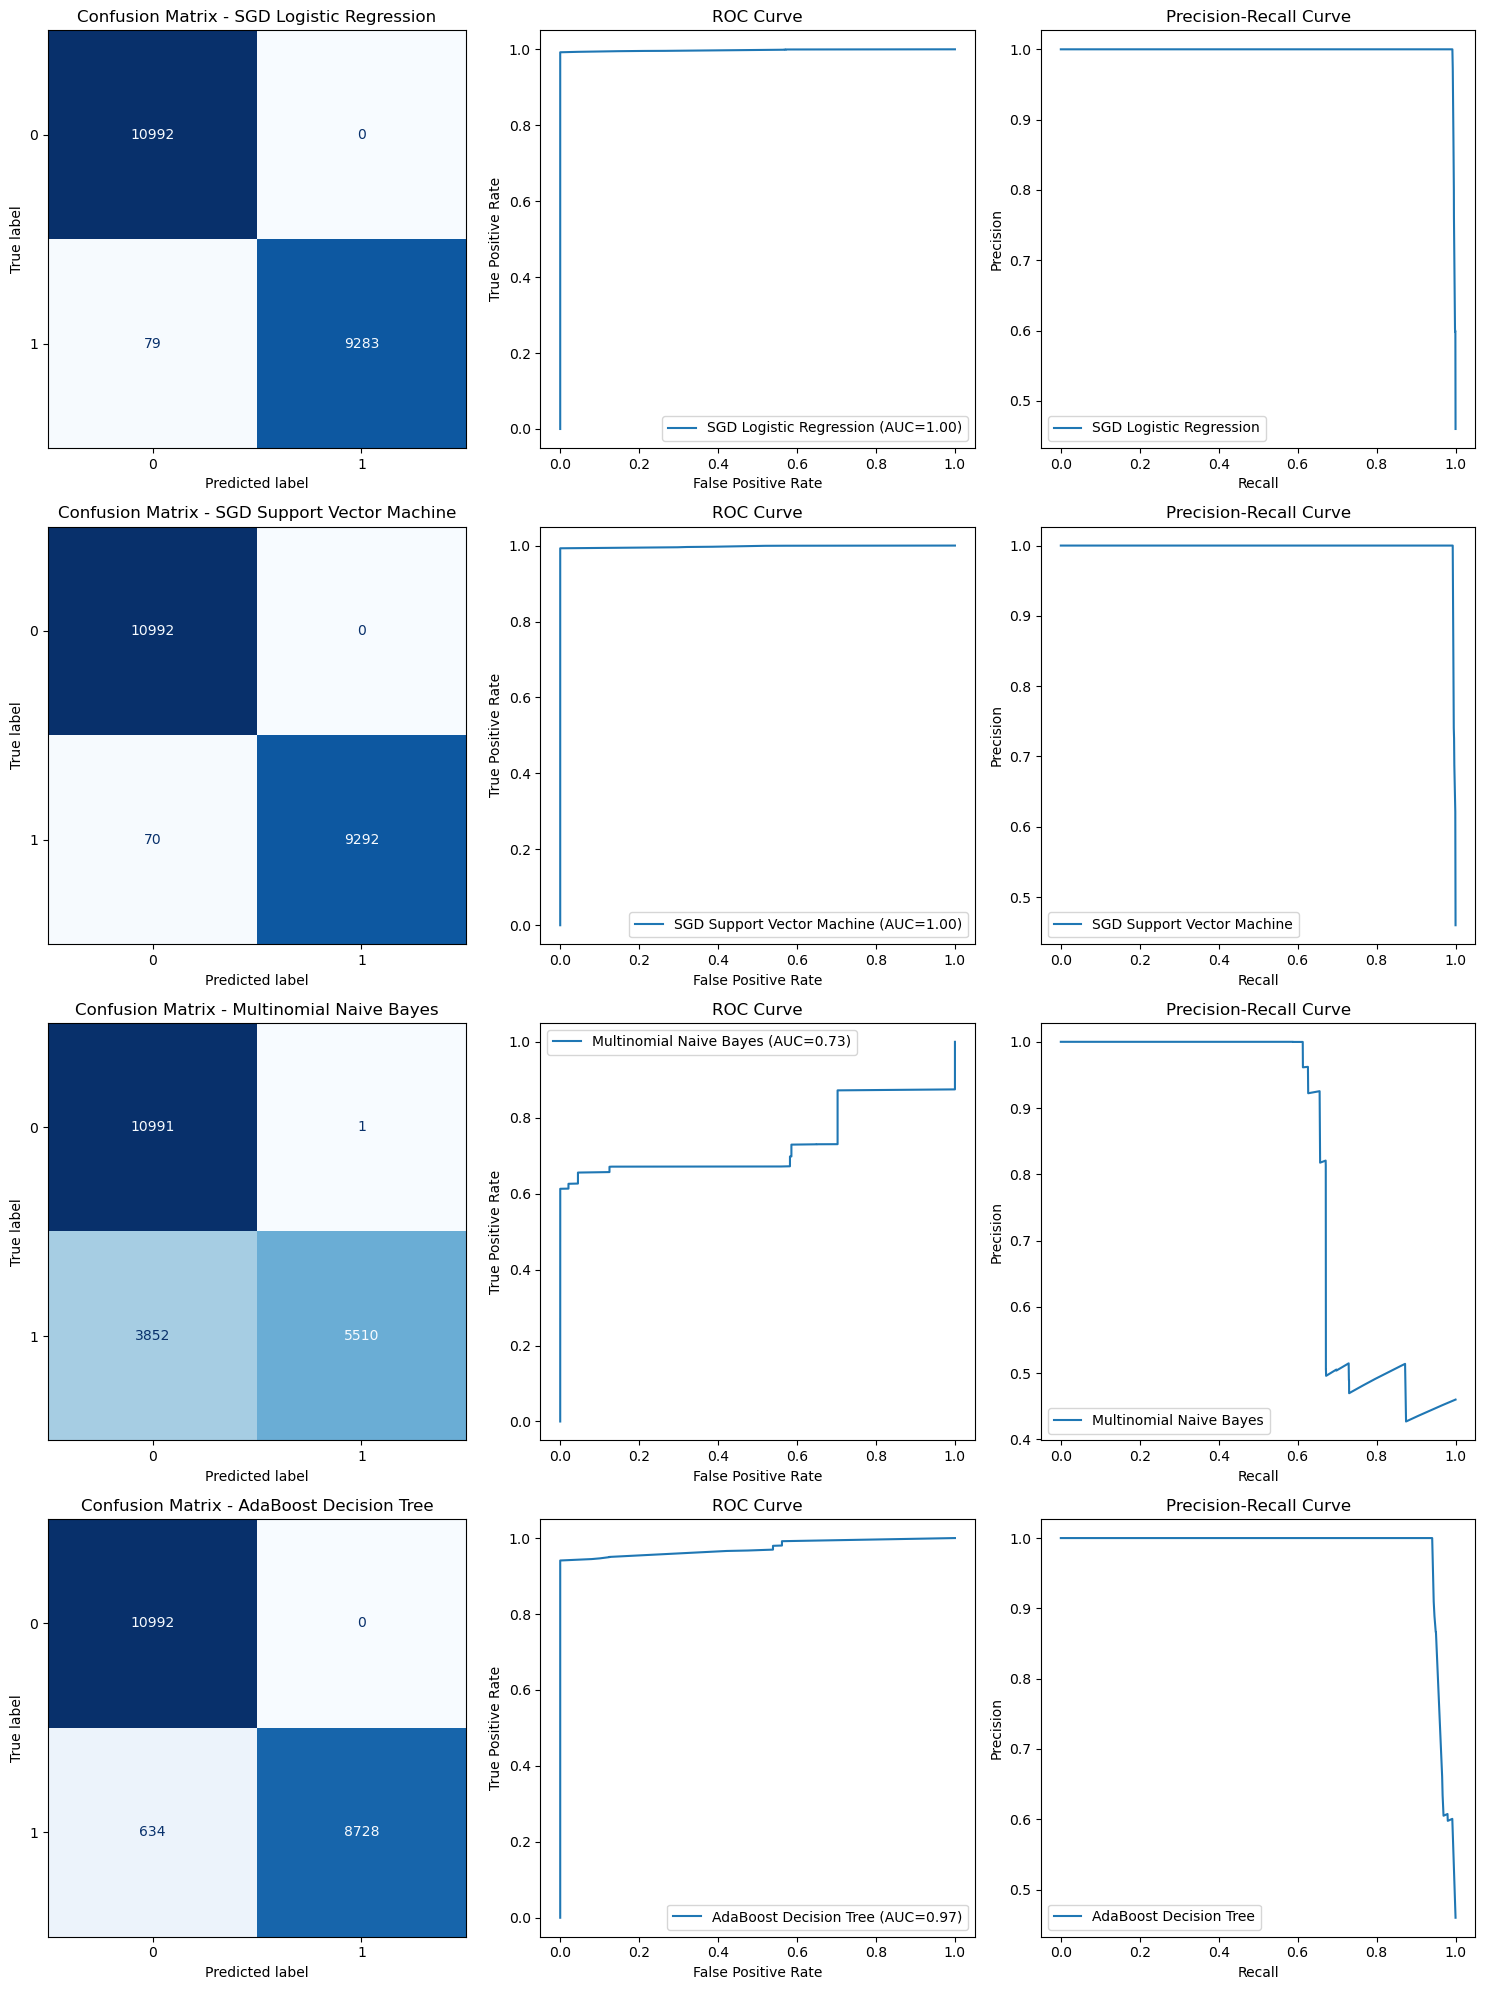

In [21]:
# Fit the models
clf_lr_pipeline_red.fit(X_train_super_reduced, y_train)
clf_svm_pipeline_red.fit(X_train_super_reduced, y_train)
clf_nb.fit(X_train_super_reduced, y_train)
clf_dt_pipeline_red.fit(X_train_super_reduced, y_train)

# Create subplots for CM, ROC, and PR curves
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # 4 rows, 3 columns (CM, PR, ROC)

for i, (clf, label) in enumerate(zip([clf_lr_pipeline_red, clf_svm_pipeline_red, clf_nb, clf_dt_pipeline_red], clf_labels)):
    
    # Predictions
    y_test_pred = clf.predict(X_test_super_reduced)
    # Use predict_proba() if available; otherwise, use decision_function()
    if hasattr(clf, "predict_proba"):
        y_test_prob = clf.predict_proba(X_test_super_reduced)[:, 1]  # Probabilities for positive class
    else:
        y_test_prob = clf.decision_function(X_test_super_reduced)  # Decision scores (not probabilities)
    
    # Confusion Matrix
    cm_test = mt.confusion_matrix(y_test, y_test_pred)
    cm_display = mt.ConfusionMatrixDisplay(cm_test)
    axes[i, 0].set_title(f"Confusion Matrix - {label}")
    cm_display.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)

    # ROC Curve
    fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
    axes[i, 1].plot(fpr, tpr, label=f"{label} (AUC={mt.roc_auc_score(y_test, y_test_prob):.2f})")
    axes[i, 1].set_title("ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="best")
    
    # Precision-Recall Curve
    precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
    axes[i, 2].plot(recall, precision, label=f"{label}")
    axes[i, 2].set_title("Precision-Recall Curve")
    axes[i, 2].set_xlabel("Recall")
    axes[i, 2].set_ylabel("Precision")
    axes[i, 2].legend(loc="best")

    # Print final metrics for comparison
    print(f"\nPerformance Metrics for {label}:")
    print(f"  Accuracy: {mt.accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC: {mt.roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"  F1 Score: {mt.f1_score(y_test, y_test_pred):.4f}")
    print(f"  Precision: {mt.precision_score(y_test, y_test_pred):.4f}")
    print(f"  Recall: {mt.recall_score(y_test, y_test_pred):.4f}")

print(f"\n")
plt.tight_layout()
plt.show()


Takeaways:
- SGD Logistic Regression & SGD SVM
  - Nearly perfect classification with no false positives and very few false negatives.  
    - Logistic Regression: 0 False Positives / 79 False Negatives.  
    - SVM: 0 False Positives / 70 False Negatives.  
  - ROC AUC = 1.00, near-perfect class separation.  
  - PR Curve is ideal, showing near-perfect recall and precision.  
- Multinomial Naive Bayes
  - More false negatives (3,852) compared to SGD models.
  - ROC AUC = 0.73, lower than the 0.93 when more variables were included.
- AdaBoost Decision Tree
  - Fewer false negatives (634) than Naive Bayes or the AdaBoost including more features. No false positives.
  - ROC AUC = 0.97 higher than the 0.90 using more features.
- SGD Logistic Regression and SVM consistently performed best, with SVM slightly outperforming LR in accuracy when more features were included.
- Reducing features improved AdaBoost significantly (from 83.3% to 96.9% accuracy), likely by reducing overfitting improving model generalization.
- Logistic Regression was much faster than SVM and AdaBoost.
- Naive Bayes was the fastest model but consistently the weakest. Surprisingly, its performance dropped when reducing features.
- All except the Naive Bayes model performed similarly or better after reducing the number of features from those selected by feature selection to eight medication variables. 
- All models predicted the negative class better than the positive class, as indicated by the higher number of false negatives compared to false positives, leading to slightly higher precision than recall.
- All of the models performed similarly comparing the metrics from cross-validation on the training set and the metrics from the heldout testing set.

**Recommendation**: Though SVM slightly outperformed Logistic Regression and AdaBoost Decision Tree models, we would recommend the Logistic Regression model for the following reasons.
  1. It is faster and computationally more efficient.
  2. It is very interpretable.
  3. It performs well with both a reduced dataset of very important features and a more expanded dataset with feature of lower importance.
  4. It generalizes well, performing consistently well using cross-validation on training data and when evaluated on unseen testing data.
     

## Data Preparation: Regression Task

- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).


#### Preprocessing & Encoding

In [22]:
# Get a copy of the data prior preprocessing for classification
df2 = df_clean.copy()

# Extract response variable
y_time = df2['time_in_hospital']
X_time = df2.drop(columns=['time_in_hospital'])

# Define categorical and numerical feature subsets
categorical_cols = X_time.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_time.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables
X_time_encoded = pd.get_dummies(X_time, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues

# Define the preprocessing pipeline
# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')


#### Review Summary Statistics of the Response


Summary Statistics for 'time_in_hospital':
count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64


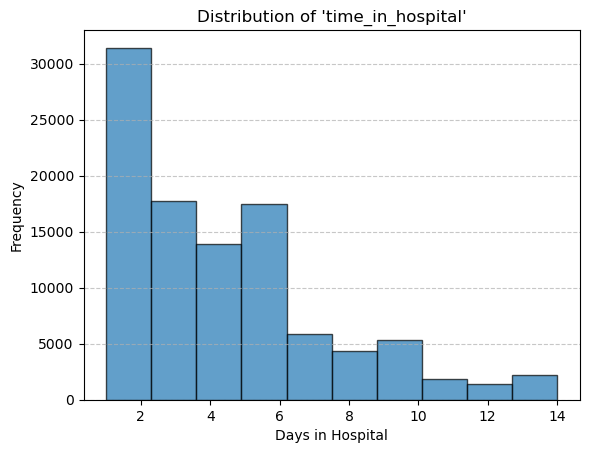

In [23]:
# Display summary statistics for the response variable
y_summary = y_time.describe()

# Print summary statistics
print("\nSummary Statistics for 'time_in_hospital':")
print(y_summary)

# Plot distribution of response variable
plt.figure()
plt.hist(y_time, edgecolor='black', alpha=0.7)
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.title("Distribution of 'time_in_hospital'")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Split the Data into a Training and Holdout Set Prior to Feature Selection

In [24]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_time_encoded, y_time, test_size=0.2, random_state=1234)


#### Feature Selection

In [25]:
# ----- LASSO Feature Selection -----
start_time = time.time()

lasso_selector = LassoCV(cv=5, random_state=1234)

# Create a pipeline with preprocessing and LASSO
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', lasso_selector)
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Retrieve feature names after transformation
feature_names = numerical_cols.tolist() + [col for col in X_train.columns if col not in numerical_cols]

# Select features with non-zero coefficients
lasso_selected_features = [feature_names[i] for i in range(len(feature_names)) if lasso_selector.coef_[i] != 0]

print(f"LASSO time: {(time.time() - start_time)/60:.2f} minutes")

# ----- Random Forest Feature Selection -----
start_time = time.time()

rf_selector = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_selector.fit(X_train, y_train)

# Get feature importances and select top features
feature_importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns)
rf_selected_features = feature_importances[feature_importances > np.percentile(feature_importances, 75)].index.tolist()  # Top 25% features

print(f"RF time: {(time.time() - start_time)/60:.2f} minutes")

# - `lasso_selected_features` is the list of features selected by LASSO
# - `rf_selected_features` is the list of features selected by Random Forest
# - `X_time` is the original dataset before encoding
# - `categorical_cols` and `numerical_cols` are already defined

# Convert feature lists to DataFrames for processing
lasso_df = pd.DataFrame({'Feature': lasso_selected_features})
rf_df = pd.DataFrame({'Feature': rf_selected_features})

# ----- Extract Original Variable Names for LASSO -----
lasso_numeric = lasso_df['Feature'][lasso_df['Feature'].isin(numerical_cols)]
lasso_categorical = lasso_df['Feature'][~lasso_df['Feature'].isin(numerical_cols)]
lasso_original_categorical = lasso_categorical.str.replace(r'_[^_]+$', '', regex=True)  # Remove one-hot encoding suffixes

# Combine numeric and cleaned categorical features
lasso_unique_features = pd.concat([lasso_numeric, lasso_original_categorical]).unique()

# ----- Extract Original Variable Names for Random Forest -----
rf_numeric = rf_df['Feature'][rf_df['Feature'].isin(numerical_cols)]
rf_categorical = rf_df['Feature'][~rf_df['Feature'].isin(numerical_cols)]
rf_original_categorical = rf_categorical.str.replace(r'_[^_]+$', '', regex=True)

# Combine numeric and cleaned categorical features
rf_unique_features = pd.concat([rf_numeric, rf_original_categorical]).unique()

# ----- Find Common & Unused Features -----
dataset_features = pd.Series(X_time.columns)  # Original dataset BEFORE encoding

# Features selected by both LASSO & RF
common_features = pd.Series(list(set(lasso_unique_features) & set(rf_unique_features)))

# Features in dataset but not selected by either method
unused_features = dataset_features[~dataset_features.isin(pd.concat([pd.Series(lasso_unique_features), pd.Series(rf_unique_features)]))]

# Print Results
print("\nLASSO Unique Selected Features (Original Variables):")
print(lasso_unique_features)

print("\nRandom Forest Unique Selected Features (Original Variables):")
print(rf_unique_features)

print("\nCommon Features Selected by Both LASSO and RF:")
print(common_features.to_list())

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO or RF):")
print(unused_features.to_list())


LASSO time: 0.38 minutes
RF time: 6.92 minutes

LASSO Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'glimepiride' 'glipizide'
 'glyburide' 'pioglitazone' 'rosiglitazone' 'insulin' 'change'
 'diabetesMed' 'readmitted']

Random Forest Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'gender' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide' 'glimepiride'
 'glipizide'

#### Create a Reduced Dataset with Important Variables

In [26]:
# Train/test split was already created. Do this to avoid leakage.

# Identify encoded features corresponding to lasso-selected original features
selected_encoded_features = [col for col in X_train.columns if any(feature in col for feature in lasso_unique_features)]

# Create a Reduced Dataset with Encoded Features
X_train_selected = X_train[selected_encoded_features].copy()
X_test_selected = X_test[selected_encoded_features].copy()  # Ensure same columns in test set

# Ensure train and test have the same columns (Test set may lack some categories)
X_test_selected = X_test_selected.reindex(columns=X_train_selected.columns, fill_value=0)

# Final check
print("Final Training Shape:", X_train_selected.shape)
print("Final Testing Shape:", X_test_selected.shape)


Final Training Shape: (81412, 2362)
Final Testing Shape: (20354, 2362)


## Modeling and Evaluation: Regression Task

- Choose and explain your evaluation metrics that you will use. Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.
- Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.
- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.
- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

#### Hyperparameter Tuning

In [27]:
# ---- Hyperparameter Tuning for LASSO ----
start_time = time.time()

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], cv=5, random_state=1234)) # Use LassoCV instead of GridSearch
])

lasso_pipeline.fit(X_train_selected, y_train)

# Get best alpha directly from LassoCV
best_alpha = lasso_pipeline.named_steps['reg'].alpha_
print(f"\nBest Alpha for LASSO: {best_alpha}")

print(f"LASSO tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for Random Forest ----
start_time = time.time()

rf_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [2, 5],  
    'max_features': ['sqrt']  
}

# Use RandomizedSearchCV for efficiency
grid_rf = RandomizedSearchCV(RandomForestRegressor(random_state=1234), 
                             param_distributions=rf_grid, n_iter=7, cv=5, 
                             scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)

# Get best RF parameters
best_rf_params = grid_rf.best_params_
print(f"\nBest Parameters for Random Forest: {best_rf_params}")

print(f"RF tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SVR (RBF) ----
# For comparison with SGDRegressor (linear), RBF is computationally too expensive with full dataset
start_time = time.time()

svr_sample = X_train_selected.sample(n=min(5000, len(X_train_selected)), random_state=1234)
y_svr_sample = y_train.loc[svr_sample.index]

param_grid_svr = {
    'reg__C': [0.1, 1, 10],
    'reg__gamma': ['scale', 'auto'],
    'reg__epsilon': [0.1, 0.2, 0.5]
}

svr_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SVR(kernel='rbf'))])
grid_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
grid_svr.fit(svr_sample, y_svr_sample)

# Extract best parameters
best_C = grid_svr.best_params_['reg__C']
best_epsilon = grid_svr.best_params_['reg__epsilon']
print(f"\nBest SVR Parameters: C={best_C}, epsilon={best_epsilon}, Kernel=rbf")
print(f"SVR tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SGDRegressor----
start_time = time.time()

param_grid_sgd = {
    'reg__alpha': [0.0001, 0.001, 0.01, 0.1],
    'reg__max_iter': [10000, 20000],
    'reg__tol': [1e-2, 1e-3],
    'reg__learning_rate': ['constant', 'optimal', 'invscaling']
}

sgd_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SGDRegressor(random_state=1234, early_stopping=True))])
grid_sgd = GridSearchCV(sgd_pipeline, param_grid_sgd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_sgd.fit(svr_sample, y_svr_sample) # Use the same sample of 5000 as used for tuning the SVR

best_sgd_params = grid_sgd.best_params_
print(f"\nBest Parameters for SGDRegressor: {best_sgd_params}")
print(f"SGDRegressor tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for XGBoost ----
# Preprocessing fixes
# Ensure column names are strings
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# # Ensure y_train is a 1D array
# y_train = y_train.ravel()

start_time = time.time()

xgb_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_xgb = RandomizedSearchCV(XGBRegressor(tree_method='hist', random_state=1234), 
                              param_distributions=xgb_grid, n_iter=7, cv=5, 
                              scoring='neg_mean_squared_error')
grid_xgb.fit(X_train_selected, y_train)

# Get best XGBoost parameters
best_xgb_params = grid_xgb.best_params_
print(f"\nBest Parameters for XGBoost: {best_xgb_params}")
print(f"XGBoost tuning time: {(time.time() - start_time)/60:.2f} minutes")



Best Alpha for LASSO: 0.0001
LASSO tuning time: 0.95 minutes

Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
RF tuning time: 2.99 minutes

Best SVR Parameters: C=10, epsilon=0.5, Kernel=rbf
SVR tuning time: 5.07 minutes

Best Parameters for SGDRegressor: {'reg__alpha': 0.001, 'reg__learning_rate': 'invscaling', 'reg__max_iter': 10000, 'reg__tol': 0.001}
SGDRegressor tuning time: 0.10 minutes

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
XGBoost tuning time: 2.42 minutes


#### Hyperparameter Tuning Details

In [28]:
# ---- Display LASSO Tuning Results ----
lasso_cv = lasso_pipeline.named_steps['reg']  # Extract the LassoCV model

lasso_results = pd.DataFrame({
    'Alpha': lasso_cv.alphas_,
    'Mean MSE': lasso_cv.mse_path_.mean(axis=1),  
    'Std MSE': lasso_cv.mse_path_.std(axis=1)  
})

lasso_results.sort_values(by='Mean MSE', ascending=True, inplace=True)  # Lower MSE is better
print("\nLASSO Hyperparameter Tuning Results:")
print(lasso_results)


# ---- Display Random Forest Tuning Results ----
rf_results = pd.DataFrame(grid_rf.cv_results_)
rf_results = rf_results[[
    'param_n_estimators', 'param_max_depth',
    'param_min_samples_split', 'param_min_samples_leaf',
    'param_max_features', 'mean_test_score', 'std_test_score'
]]
rf_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
rf_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  # Higher neg MSE is better
print("\nRandom Forest Hyperparameter Tuning Results:")
print(rf_results)


# ---- Display SVR Tuning Results ----
svr_results = pd.DataFrame(grid_svr.cv_results_)
svr_results = svr_results[[
    'param_reg__C', 'param_reg__gamma', 'param_reg__epsilon',
    'mean_test_score', 'std_test_score'
]]
svr_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
svr_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  
print("\nSVR Hyperparameter Tuning Results:")
print(svr_results)


# ---- Display SGDRegressor Tuning Results ----
sgd_results = pd.DataFrame(grid_sgd.cv_results_)
sgd_results = sgd_results[[
    'param_reg__alpha', 'param_reg__max_iter', 'param_reg__tol', 'param_reg__learning_rate',
    'mean_test_score', 'std_test_score'
]]
sgd_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
sgd_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nSGDRegressor Hyperparameter Tuning Results:")
print(sgd_results)


# ---- Display XGBoost Tuning Results ----
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
xgb_results = xgb_results[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
    'mean_test_score', 'std_test_score'
]]
xgb_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
xgb_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nXGBoost Hyperparameter Tuning Results:")
print(xgb_results)



LASSO Hyperparameter Tuning Results:
      Alpha  Mean MSE   Std MSE
6    0.0001  4.922157  0.061825
5    0.0010  5.006710  0.065134
4    0.0100  5.466042  0.073354
3    0.1000  6.520046  0.097922
2    1.0000  7.997807  0.105850
0  100.0000  8.937581  0.105310
1   10.0000  8.937581  0.105310

Random Forest Hyperparameter Tuning Results:
   param_n_estimators param_max_depth  param_min_samples_split  \
6                 200            None                        5   
4                 200            None                       10   
0                 100            None                       10   
1                 100            None                        5   
2                 200              20                       10   
5                 200              20                        5   
3                 200              10                       10   

   param_min_samples_leaf param_max_features  Mean MSE   Std MSE  
6                       2               sqrt -5.579733  0.096276

#### Fit and Evaluate Regression Models on the Holdout Set

In [29]:
start_time_total = time.time()  # Track total time

# Define model labels
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Store training and prediction times
model_times = {"Training Time (min)": {}, "Prediction Time (sec)": {}}


# ---- Update pipelines with with best parameters ----
# Update Lasso pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', Lasso(alpha=best_alpha, random_state=1234))  # Use Lasso (not LassoCV)
])

# Update RF model with modified best parameters, set n_estimators manually (error/time tradeoff isn't worth it)
# Remove "reg__" prefix from best parameters
best_rf_params_cleaned = {k.replace("reg__", ""): v for k, v in best_rf_params.items()}
best_rf_params_cleaned['n_estimators'] = 50  # Manually reduce to 50 trees
rf_model = RandomForestRegressor(**best_rf_params_cleaned, random_state=1234)  # No pipeline needed

# Update SGDRegressor pipeline
best_sgd_params = {k.replace("reg__", ""): v for k, v in grid_sgd.best_params_.items()}
best_sgd_params['random_state'] = 1234  # Ensure reproducibility
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', SGDRegressor(**best_sgd_params))
])

# Update XGB model
xgb_best_params = {k.replace("reg__", ""): v for k, v in best_xgb_params.items()}
xgb_model = XGBRegressor(**xgb_best_params, tree_method='hist', random_state=1234)


# ---- Preprocessing Fixes for XGBoost ----
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# y_train = y_train.ravel()  # Ensure y_train is a 1D array


# ---- Fit the tuned models ----
start_time = time.time()
lasso_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["LASSO Regression"] = (time.time() - start_time) / 60  # Convert to minutes

start_time = time.time()
rf_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["Random Forest Regression"] = (time.time() - start_time) / 60

start_time = time.time()
sgd_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["SGD Regression"] = (time.time() - start_time) / 60

start_time = time.time()
xgb_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["XGBoost"] = (time.time() - start_time) / 60


# ---- Make predictions ----
start_time = time.time()
y_test_pred_lasso = lasso_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["LASSO Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_rf = rf_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["Random Forest Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_sgd = sgd_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["SGD Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_xgb = xgb_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["XGBoost"] = time.time() - start_time


# Function for evaluating models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    return {"Model": model_name, "MSE": mse, "MAE": mae, "R²": r2}

# Store results
results = []
for y_pred, label in zip([y_test_pred_lasso, y_test_pred_rf, y_test_pred_sgd, y_test_pred_xgb], reg_labels):
    results.append(evaluate_model(y_test, y_pred, label))

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df)

# Print training, prediction and total times 
print("\nModel Training Times (in minutes):")
for model, time_taken in model_times["Training Time (min)"].items():
    print(f"{model}: {time_taken:.2f} minutes")

print("\nModel Prediction Times (in seconds):")
for model, time_taken in model_times["Prediction Time (sec)"].items():
    print(f"{model}: {time_taken:.2f} seconds")

end_time_total = time.time()
print(f"\nTotal Elapsed Time: {(end_time_total - start_time_total)/60:.2f} minutes")



Performance Metrics for LASSO Regression:
  Mean Squared Error (MSE): 4.8428
  Mean Absolute Error (MAE): 1.6569
  R² Score: 0.4500

Performance Metrics for Random Forest Regression:
  Mean Squared Error (MSE): 5.4340
  Mean Absolute Error (MAE): 1.7723
  R² Score: 0.3828

Performance Metrics for SGD Regression:
  Mean Squared Error (MSE): 4.9112
  Mean Absolute Error (MAE): 1.6579
  R² Score: 0.4422

Performance Metrics for XGBoost:
  Mean Squared Error (MSE): 4.6258
  Mean Absolute Error (MAE): 1.5962
  R² Score: 0.4746

Final Model Comparison:
                      Model       MSE       MAE        R²
0          LASSO Regression  4.842779  1.656895  0.449960
1  Random Forest Regression  5.434037  1.772341  0.382806
2            SGD Regression  4.911203  1.657874  0.442189
3                   XGBoost  4.625818  1.596240  0.474603

Model Training Times (in minutes):
LASSO Regression: 0.72 minutes
Random Forest Regression: 0.23 minutes
SGD Regression: 0.16 minutes
XGBoost: 0.08 minutes

#### Plot the Residuals

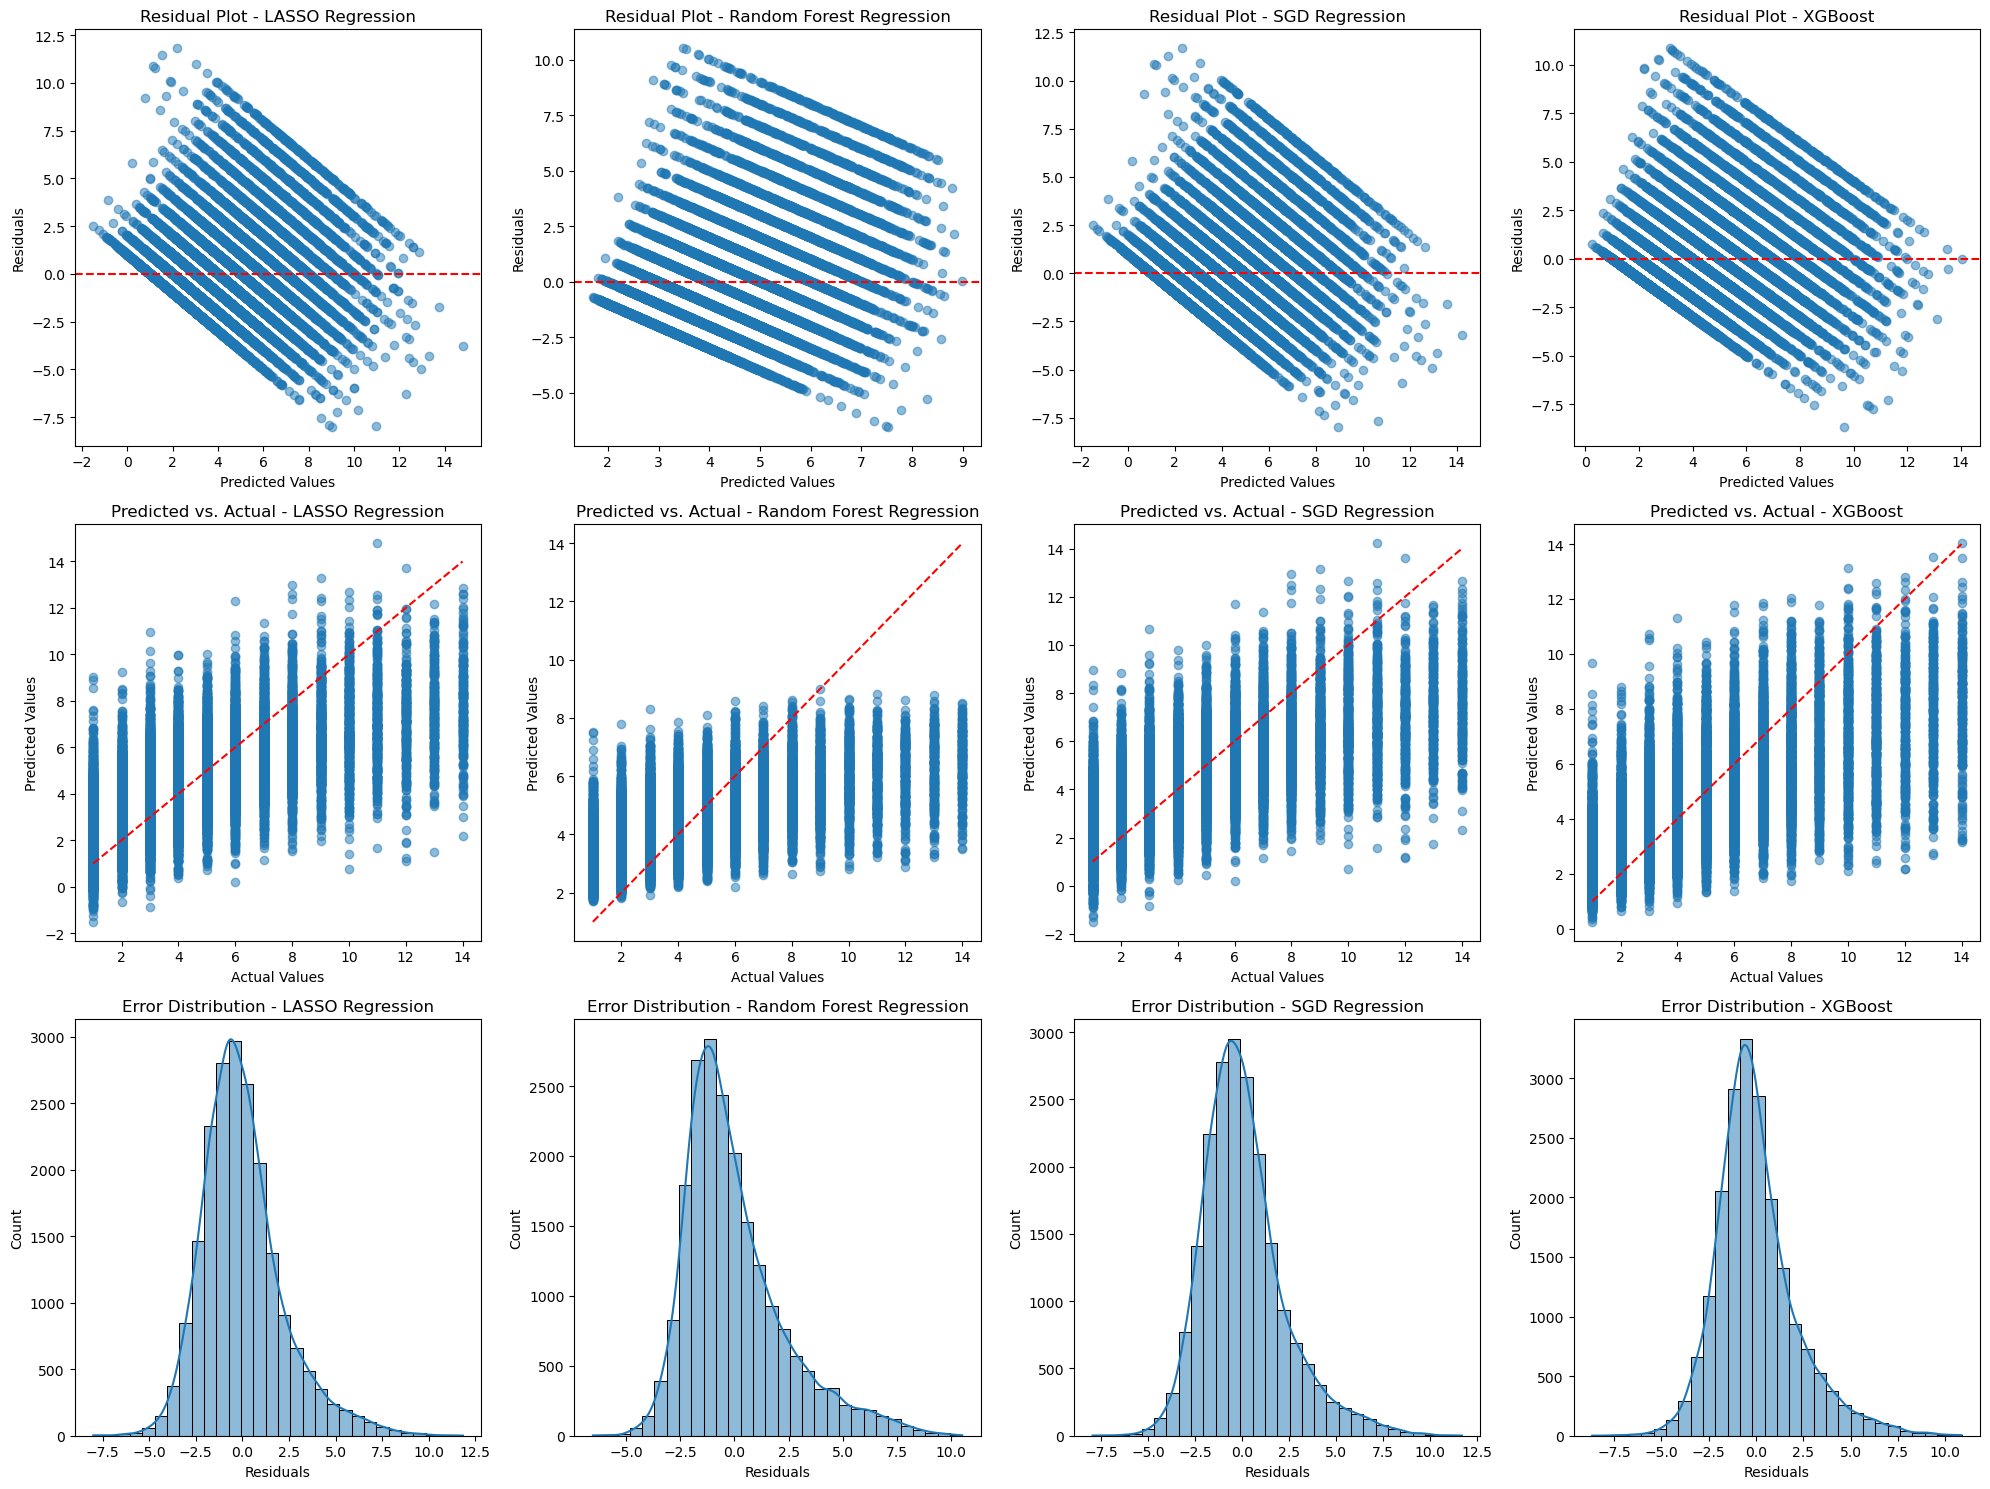

In [30]:
# Define regression models & labels
regressors = [lasso_pipeline, rf_model, sgd_pipeline, xgb_model]
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Create subplots (3 rows: Residuals, Predicted vs Actual, Error Distribution)
fig, axes = plt.subplots(3, len(regressors), figsize=(len(regressors) * 5, 15))

for i, (model, label) in enumerate(zip(regressors, reg_labels)):
    
    # Predictions
    y_test_pred = model.predict(X_test_selected)
    residuals = y_test - y_test_pred  # Compute residuals (errors)

    # ---- Residual Plot ----
    axes[0, i].scatter(y_test_pred, residuals, alpha=0.5)
    axes[0, i].axhline(y=0, color="r", linestyle="--")  # Reference line at 0
    axes[0, i].set_title(f"Residual Plot - {label}")
    axes[0, i].set_xlabel("Predicted Values")
    axes[0, i].set_ylabel("Residuals")

    # ---- Predicted vs. Actual ----
    axes[1, i].scatter(y_test, y_test_pred, alpha=0.5)
    axes[1, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
    axes[1, i].set_title(f"Predicted vs. Actual - {label}")
    axes[1, i].set_xlabel("Actual Values")
    axes[1, i].set_ylabel("Predicted Values")

    # ---- Error Distribution ----
    sns.histplot(residuals, bins=30, kde=True, ax=axes[2, i])
    axes[2, i].set_title(f"Error Distribution - {label}")
    axes[2, i].set_xlabel("Residuals")

plt.tight_layout()
plt.show()


#### Plot Learning Curves

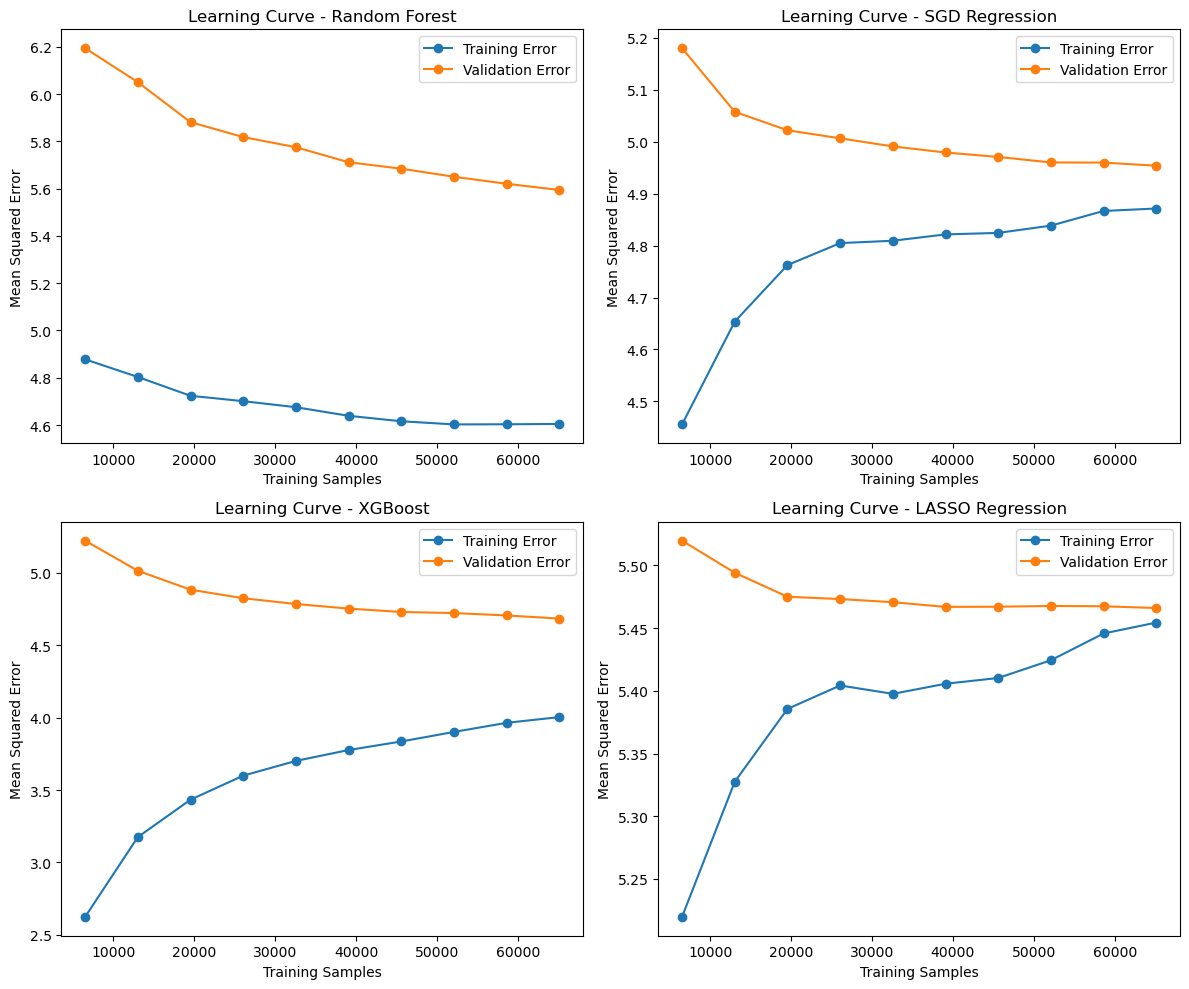

In [31]:
from sklearn.model_selection import learning_curve

# Apply fixes: Increase iterations, ensure scaling, and adjust alpha
lasso_pipeline.set_params(reg__max_iter=5000, reg__alpha=0.01)

# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Convert scores to positive MSE
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Error")
    plt.xlabel("Training Samples")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend(loc="best")

# Plot for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = {
    "LASSO Regression": lasso_pipeline,
    "Random Forest": rf_model,
    "SGD Regression": sgd_pipeline,
    "XGBoost": xgb_model
}

for ax, (name, model) in zip(axes.ravel(), models.items()):
    plot_learning_curve(model, X_train_selected, y_train, f"Learning Curve - {name}")
    plt.sca(ax)

plt.tight_layout()
plt.show()


#### Interpreting the Lasso Model

In [32]:
# Extract the trained LASSO model from the pipeline
lasso_model = lasso_pipeline.named_steps['reg']

# Get feature names from the preprocessor (if applicable)
if 'preprocessor' in lasso_pipeline.named_steps:
    feature_names = list(X_train_selected.columns)  # If no preprocessing was applied
else:
    feature_names = list(X_train_selected.columns)  # Use raw feature names

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# Remove zero coefficients
lasso_nonzero = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]

# Count number of selected features
num_nonzero_features = lasso_nonzero.shape[0]

# Get top 20 important features (sorted by absolute coefficient value)
top_20_features = lasso_nonzero.assign(AbsCoefficient=lasso_nonzero['Coefficient'].abs()) \
                               .sort_values(by='AbsCoefficient', ascending=False) \
                               .drop(columns=['AbsCoefficient']) \
                               .head(20)

# Print results
print(f"\nTotal Number of Non-Zero Coefficients: {num_nonzero_features}")
print("\nTop 20 Most Important Features in LASSO:")
print(top_20_features)



Total Number of Non-Zero Coefficients: 924

Top 20 Most Important Features in LASSO:
                                       Feature  Coefficient
641                                 diag_1_731     4.803175
528                                 diag_1_583     3.958205
833                                 diag_1_V57     3.850634
126   medical_specialty_Pediatrics_Pulmonology     3.683990
286                                 diag_1_295     3.349534
287                                 diag_1_296     2.785223
186                                 diag_1_161     2.760550
304                                 diag_1_312     2.756563
221                                 diag_1_208     2.616360
830                                 diag_1_V54     2.425186
2297                                diag_3_V53     2.379746
281                                 diag_1_290     2.319377
977                                 diag_2_312     2.298668
298                                 diag_1_307     2.281423
285           

## Deployment

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

## Exceptional Work

- You have free reign to provide additional modeling.
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?